# Predicting Daily Milk Yield - Fall 2025 ML Course Project

In [43]:
# Felipe Benitez, feb478
# Edwin Torres, ert863
# Gora Bepary, gcb883
# Sankarsh Narayanan, skn636

'''
This project involves analyzing and predicting daily milk yield of dairy cows using a rich dataset containing animal, farm, environmental, and management features.
We will perform data loading, cleaning, exploratory data analysis (EDA), feature engineering, and model building with advanced machine learning techniques.
'''

'\nThis project involves analyzing and predicting daily milk yield of dairy cows using a rich dataset containing animal, farm, environmental, and management features.\nWe will perform data loading, cleaning, exploratory data analysis (EDA), feature engineering, and model building with advanced machine learning techniques.\n'

# Data Loading & Initial Inspection 1

### Data loading 1.1

Import statements necessary for data loading and exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Loads the test and train data from the cvs files into pandas dataframes

In [25]:
# Load datasets
train = pd.read_csv('../data/cattle_data_train.csv')
test = pd.read_csv('../data/cattle_data_test.csv')

### Data exploration 1.2

Shows an initial overview of the data, including the shape of the train and test, the first 5 rows of the train set, and a summary of the numerical and categorical features.
The data exploration is done only on the training dataset to ensure there is no leakage, and ensure unbiased model evaluation.

In [34]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Show first few rows of train
print("Train head:")
display(train.head())

# Data types and non-null counts
print("Train info:")
print(train.info())

# Numeric summary
print("Numerical feature summary:")
display(train.describe())

# Categorical summary
print("Categorical feature summary:")
display(train.select_dtypes(include=['object']).describe())

Train shape: (210000, 36)
Test shape: (40000, 35)
Train head:


,Cattle_ID,Breed,Climate_Zone,Management_System,Age_Months,Weight_kg,Parity,Lactation_Stage,Days_in_Milk,Feed_Type,...,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Date,Farm_ID,Feed_Quantity_lb,Mastitis,Milk_Yield_L
0,CATTLE_133713,Holstein,Tropical,Intensive,114,544.8,4,Mid,62,Concentrates,...,0,1,6.31,3.0,12,2024-01-15,FARM_0301,36.8235,1,12.192634
1,CATTLE_027003,Holstein,Arid,Mixed,136,298.9,4,Mid,213,Crop_Residues,...,0,0,17.16,4.0,12,2023-10-31,FARM_0219,NaN,0,14.717031
2,CATTLE_122459,Holstein,Tropical,Semi_Intensive,64,336.6,4,Late,16,Hay,...,1,0,4.07,3.5,12,2024-05-20,FARM_0802,16.0965,0,14.006142
3,CATTLE_213419,Jersey,Mediterranean,Intensive,58,370.5,1,Early,339,Crop_Residues,...,0,0,10.23,3.0,24,2024-07-22,FARM_0034,40.7925,0,24.324325
4,CATTLE_106260,Guernsey,Subtropical,Intensive,84,641.5,6,Early,125,Mixed_Feed,...,1,1,20.68,3.0,12,2023-01-03,FARM_0695,33.7365,1,12.023074


Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Cattle_ID                210000 non-null  object 
 1   Breed                    210000 non-null  object 
 2   Climate_Zone             210000 non-null  object 
 3   Management_System        210000 non-null  object 
 4   Age_Months               210000 non-null  int64  
 5   Weight_kg                210000 non-null  float64
 6   Parity                   210000 non-null  int64  
 7   Lactation_Stage          210000 non-null  object 
 8   Days_in_Milk             210000 non-null  int64  
 9   Feed_Type                210000 non-null  object 
 10  Feed_Quantity_kg         199519 non-null  float64
 11  Feeding_Frequency        210000 non-null  int64  
 12  Water_Intake_L           210000 non-null  float64
 13  Walking_Distance_km      210000 non-null  float

,Age_Months,Weight_kg,Parity,Days_in_Milk,Feed_Quantity_kg,Feeding_Frequency,Water_Intake_L,Walking_Distance_km,Grazing_Duration_hrs,Rumination_Time_hrs,...,Anthrax_Vaccine,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Feed_Quantity_lb,Mastitis,Milk_Yield_L
count,210000.000000,210000.000000,210000.000000,210000.000000,199519.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,...,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,199519.000000,210000.000000,210000.000000
mean,83.483905,499.930430,3.500395,182.112967,12.014793,2.999119,80.036850,4.034754,6.056710,0.256557,...,0.600381,0.598814,0.599824,0.600824,8.747584,3.394726,12.302438,26.492720,0.099976,15.589156
std,34.648982,144.659172,1.707383,105.051486,3.969247,1.413147,14.987677,1.928529,2.867575,6.115351,...,0.489821,0.490140,0.489935,0.489730,5.901473,0.632831,4.298998,8.741282,0.299969,5.352079
min,24.000000,250.000000,1.000000,1.000000,2.370284,1.000000,14.207737,0.500000,1.000000,-8.808053,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000,6.615000,0.000000,-5.700324
25%,54.000000,374.200000,2.000000,91.000000,9.283265,2.000000,69.919162,2.650000,4.000000,-4.383302,...,0.000000,0.000000,0.000000,0.000000,4.270000,3.000000,12.000000,20.506500,0.000000,11.822207
50%,83.000000,500.200000,3.000000,182.000000,12.002254,3.000000,80.016973,4.000000,6.000000,-0.818631,...,1.000000,1.000000,1.000000,1.000000,7.710000,3.500000,12.000000,26.460000,0.000000,15.145871
75%,114.000000,625.700000,5.000000,273.000000,14.708920,4.000000,90.119812,5.350000,8.000000,4.051704,...,1.000000,1.000000,1.000000,1.000000,12.410000,4.000000,12.000000,32.413500,0.000000,18.884708
max,143.000000,750.000000,6.000000,364.000000,25.454207,5.000000,149.960210,12.000000,14.000000,31.263406,...,1.000000,1.000000,1.000000,1.000000,38.670000,5.000000,24.000000,55.125000,1.000000,44.555285


Categorical feature summary:


,Cattle_ID,Breed,Climate_Zone,Management_System,Lactation_Stage,Feed_Type,Date,Farm_ID
count,210000,210000,210000,210000,210000,210000,210000,210000
unique,209966,7,6,5,3,8,1095,1000
top,CATTLE_139671,Holstein,Temperate,Intensive,Mid,Dry_Fodder,2024-03-15,FARM_0842
freq,2,104775,35224,42225,83895,26558,235,252


This shows:
* There are 35 features.
* The features have different date types (object, int64, and float64).
    * Objects can be unique identifiers, categorical variables, and even some types that don't make sense, like the date
    * int64s are discrete numerical variables, or a boolean (eg: vaccination status)
    * float64s are continuous variables
* Mean, standard deviation, min, max, and IQR for all numerical features
* Count, unique values, most common, and frequency of most common value for all objects


### Numerical features 1.2.1

Finds the number of missing values for each feature, and what percent of the total number of records it is.
We found that the Feed_Quantity_lb, Feed_Quantity_kg, and Housing_Score were the only features with missin values, with the feed quantity features missing about 5% of the values. Additionally, all records that are missing Feed_Quantity_lb is also missing Feed_Quantity_kg, indicating that there was a data entry issue for these records, as they both are the same feature, just formatted with a different unit. However, only 360 records were missing all 3 features, indicating no clear relationship between records missing the feed quanitity and housing score.

In [37]:
# Missing values count per column
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values per column:")
display(missing)

# Missing value percentages
missing_pct = (missing / len(train)) * 100
print("Missing value percentages per column:")
print(missing_pct)

Missing values per column:


Feed_Quantity_kg    10481
Feed_Quantity_lb    10481
Housing_Score        6279
dtype: int64

Missing value percentages per column:
Feed_Quantity_kg    4.990952
Feed_Quantity_lb    4.990952
Housing_Score       2.990000
dtype: float64


In [ ]:
cols_with_missing = ['Feed_Quantity_kg', 'Feed_Quantity_lb']
missing_flags = train[cols_with_missing].isnull()

# Rows where all three columns are missing
all_missing_rows = missing_flags.all(axis=1)

# Rows where any of the three columns are missing
any_missing_rows = missing_flags.any(axis=1)

# Check if all rows with any missing values are exactly those with all missing values
same_missing_rows = all_missing_rows.equals(any_missing_rows)

# To see the rows themselves
rows_with_missing = train[any_missing_rows]

print("Are missing values all the 2 feed quantity features?", same_missing_rows)
print("Count of rows with missing values:", any_missing_rows.sum())
print("Count of rows with all these columns missing:", all_missing_rows.sum())

Are missing values all from the same rows? True
Count of rows with missing values: 10481
Count of rows with all these columns missing: 10481


In [ ]:
cols_with_missing = ['Feed_Quantity_kg', 'Housing_Score']
missing_flags = train[cols_with_missing].isnull()

# Rows where all three columns are missing
all_missing_rows = missing_flags.all(axis=1)

# Rows where any of the three columns are missing
any_missing_rows = missing_flags.any(axis=1)

# Check if all rows with any missing values are exactly those with all missing values
same_missing_rows = all_missing_rows.equals(any_missing_rows)

# To see the rows themselves
rows_with_missing = train[any_missing_rows]

print("Are missing values all between feed quantity and housing score features?", same_missing_rows)
print("Count of rows with missing values:", any_missing_rows.sum())
print("Count of rows with all these columns missing:", all_missing_rows.sum())

Are missing values all from the same rows? False
Count of rows with missing values: 16400
Count of rows with all these columns missing: 360


Displays a distribution plot of the target variable (Milk_Yield_L). This distribution plot also shows that there are negative values for milk yield, which logically does not make sense to have. There are a variety of possible reasons, including simple mis-entry with an added negative sign, or more systemic issues that are not easily proven with the available data.

Also displays a correlation heatmap for numerical features, showing the correlation between all numerical features. There are 2 major observations on this heatmap - Previous_Week_Avg_Yield and Rumination_Time_Hrs have a correlation of 1, and so do Feed_Quantity_lb and Feed_Quantity_kg. The first relationship does not have an easy answer, but the second relationship again indicates that one of those is simply the same as the other with a change in the unit

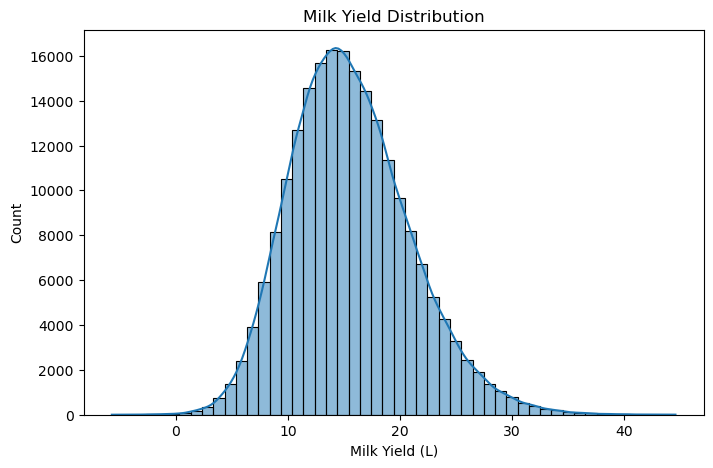

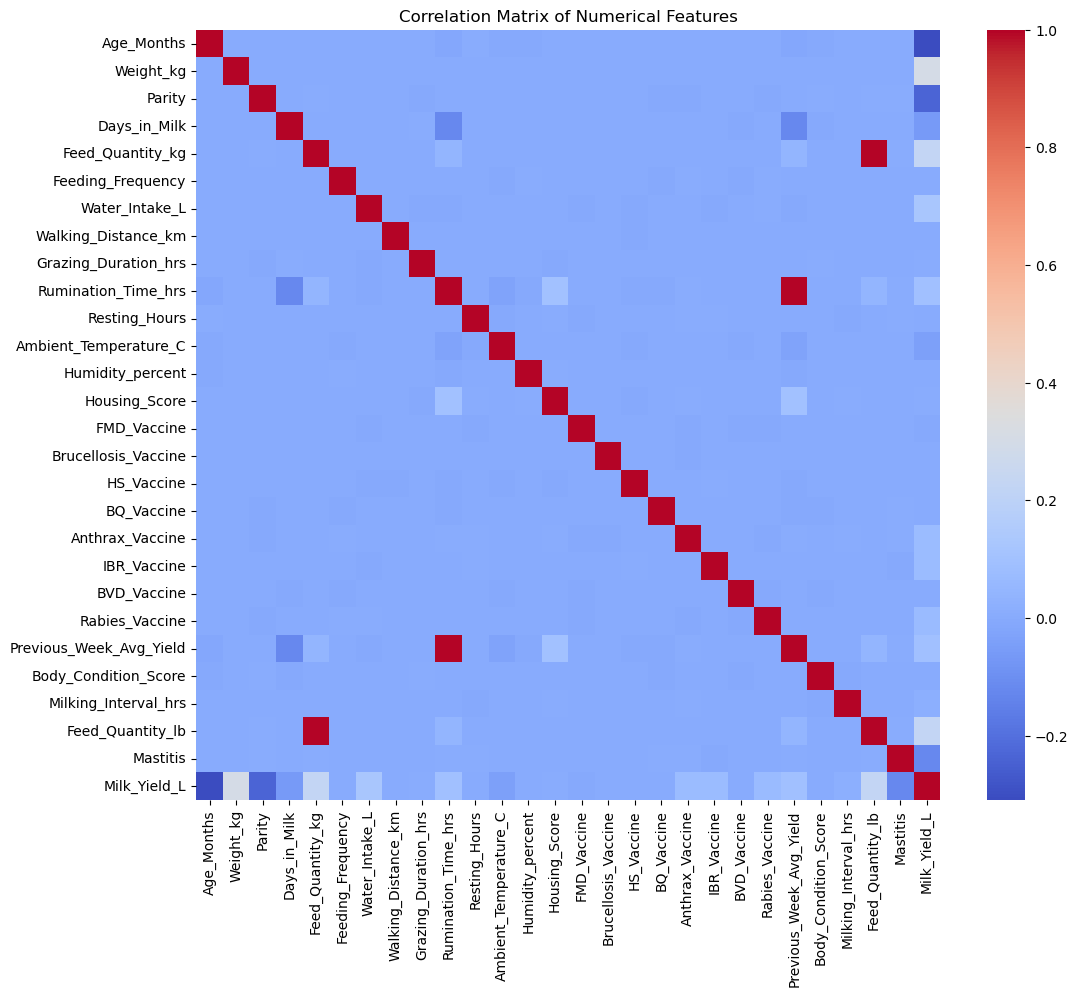

In [47]:
# Distribution plot of target variable
plt.figure(figsize=(8, 5))
sns.histplot(train['Milk_Yield_L'], bins=50, kde=True)
plt.title('Milk Yield Distribution')
plt.xlabel('Milk Yield (L)')
plt.ylabel('Count')
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 10))
numeric_cols = train.select_dtypes(include=[np.number]).columns
corr = train[numeric_cols].corr()
sns.heatmap(corr, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The following takes a more granular view on the heatmap above, only looking at the correlation between the numerical features and the target. This shows that the weight, feed quantity, water intake, mastitis, parity, and age have a relatively strong correlation with the milk yield

In [30]:
# Select numeric columns only
numeric_cols = train.select_dtypes(include=[np.number]).columns
target_col = 'Milk_Yield_L'
# Calculate correlations with target
target_correlations = train[numeric_cols].corr()[target_col].sort_values(ascending=False)

# Display correlation coefficients excluding the target correlating with itself
print("Correlation of numerical features with the target (Milk_Yield_L):")
print(target_correlations.drop(target_col))


Correlation of numerical features with the target (Milk_Yield_L):
Weight_kg                  0.300464
Feed_Quantity_lb           0.223631
Feed_Quantity_kg           0.223288
Water_Intake_L             0.124911
Rumination_Time_hrs        0.089823
Previous_Week_Avg_Yield    0.089823
IBR_Vaccine                0.072263
Anthrax_Vaccine            0.069642
Rabies_Vaccine             0.068618
Milking_Interval_hrs       0.014734
Grazing_Duration_hrs       0.004350
Housing_Score              0.004008
Humidity_percent           0.002153
Brucellosis_Vaccine        0.002089
BVD_Vaccine                0.000491
Feeding_Frequency          0.000380
HS_Vaccine                -0.000034
BQ_Vaccine                -0.000466
Walking_Distance_km       -0.001538
Body_Condition_Score      -0.001647
Resting_Hours             -0.001653
FMD_Vaccine               -0.002477
Ambient_Temperature_C     -0.042036
Days_in_Milk              -0.062554
Mastitis                  -0.122614
Parity                    -0.23656

This displays a histrogram with KDE of all numeric columns, whether they're discrete or continuous variables, so that we can gain an accurate understanding of the distribution of all the different features. One oddity to note is that the Rumination_Time_Hrs feature contains negative values, which is logically not possible.

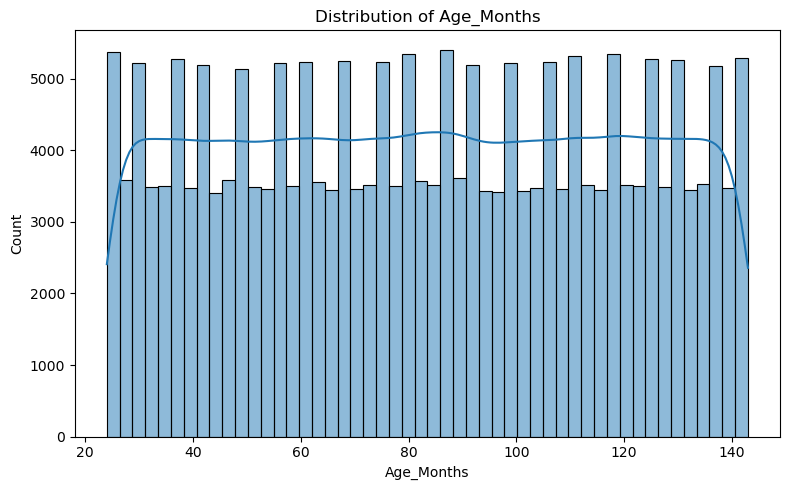

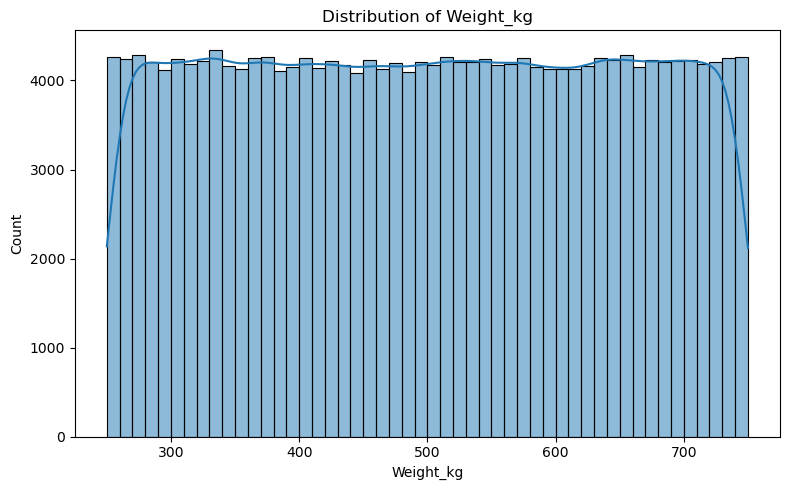

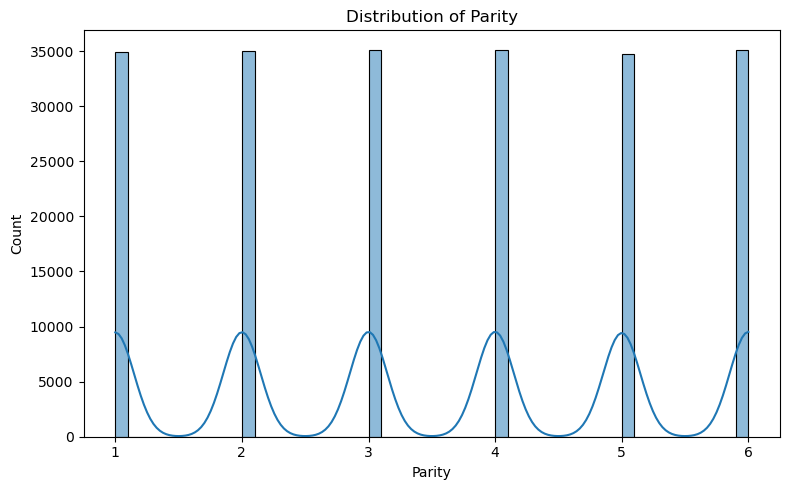

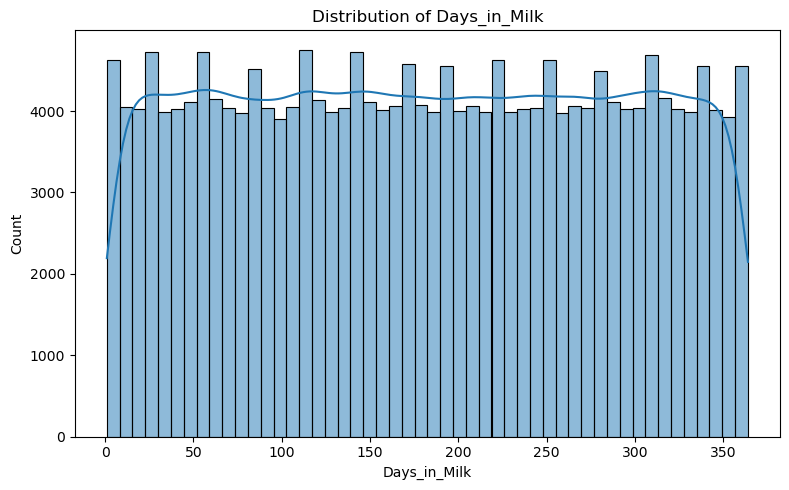

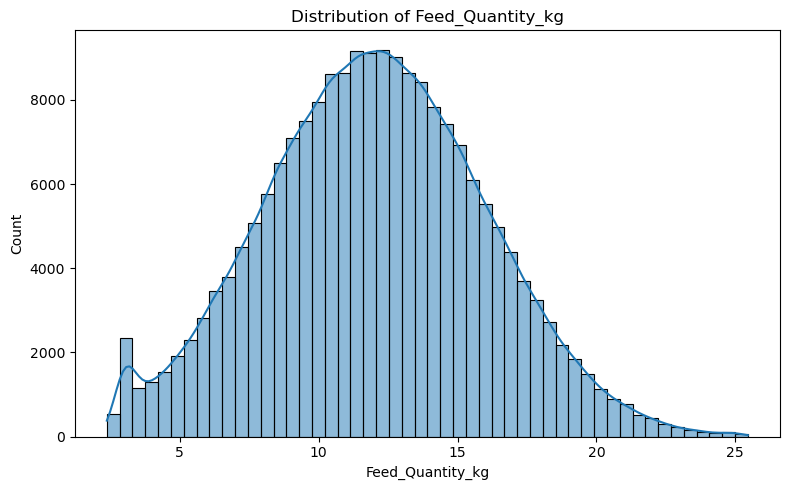

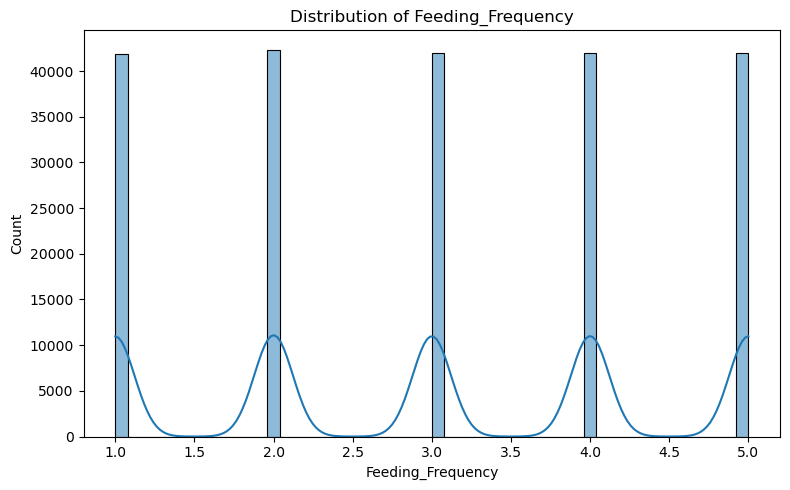

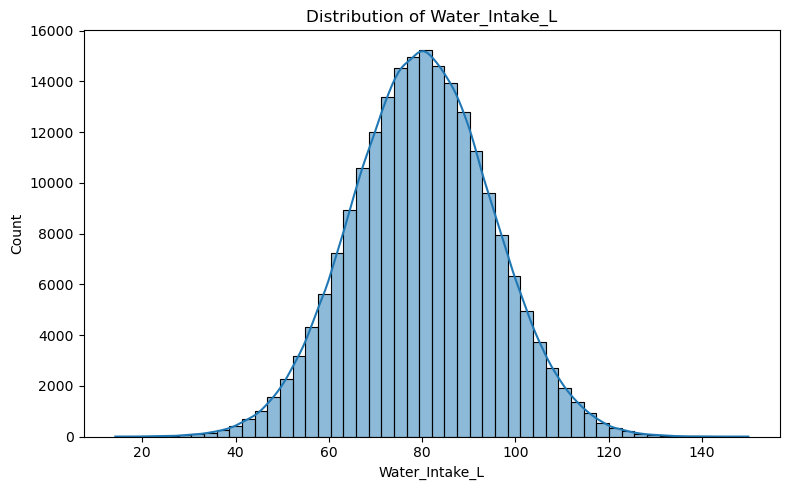

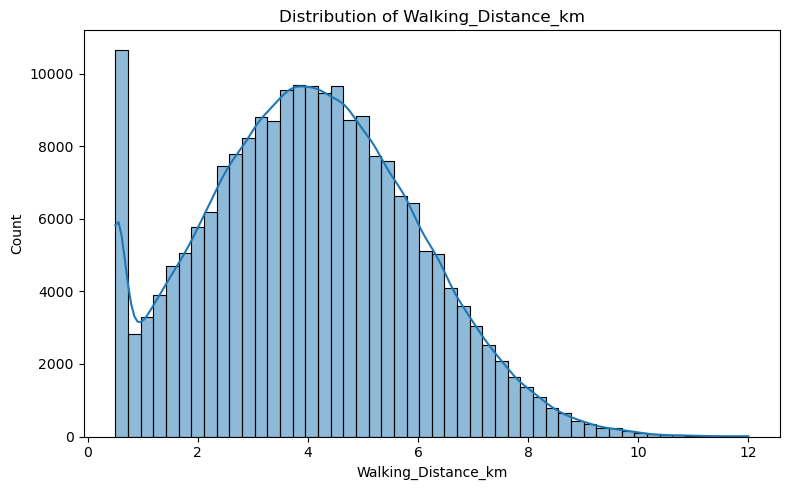

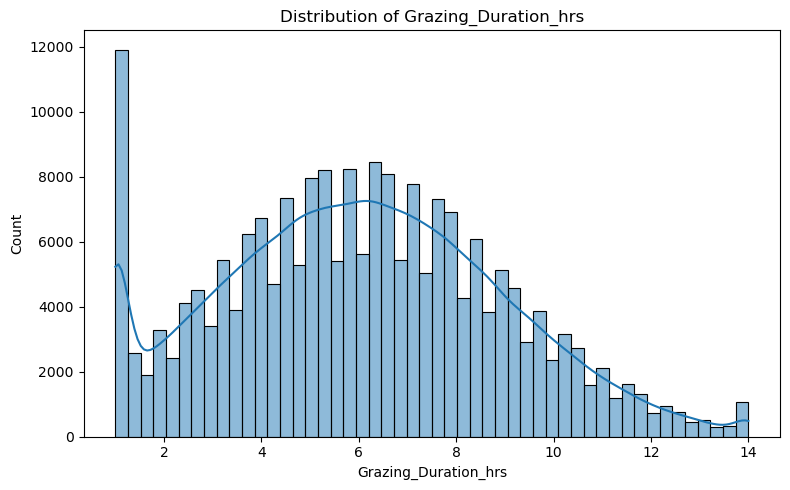

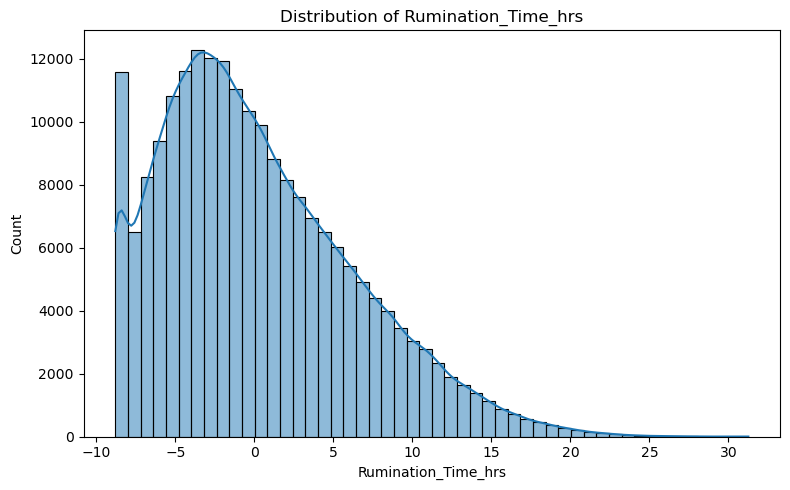

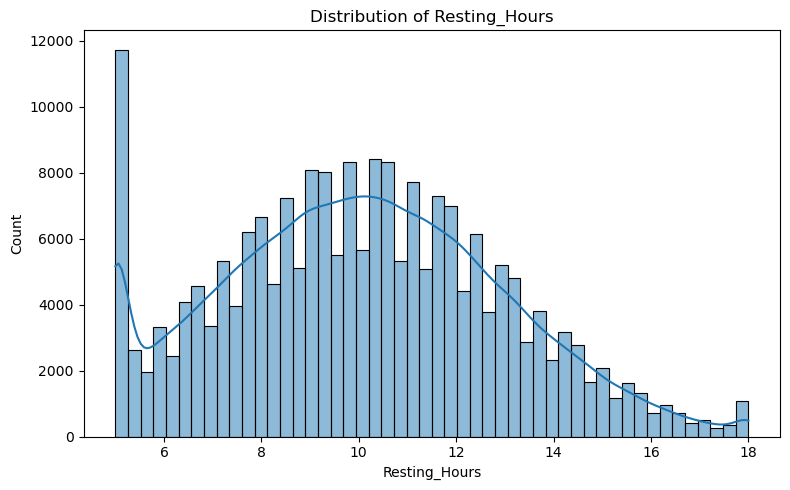

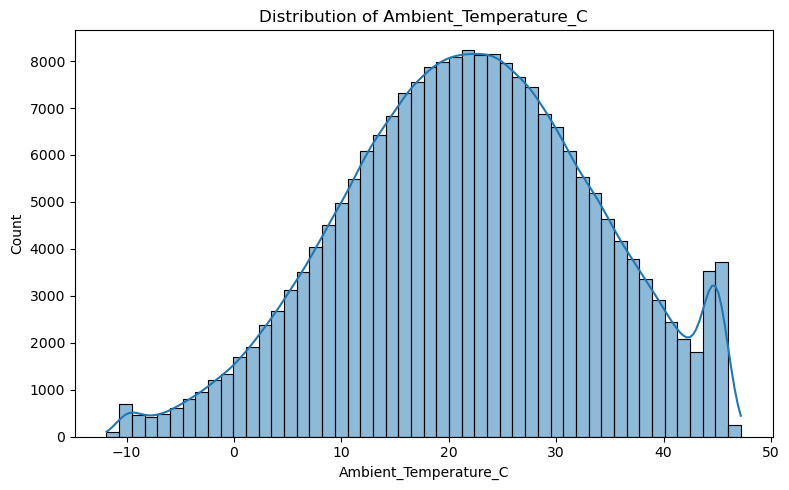

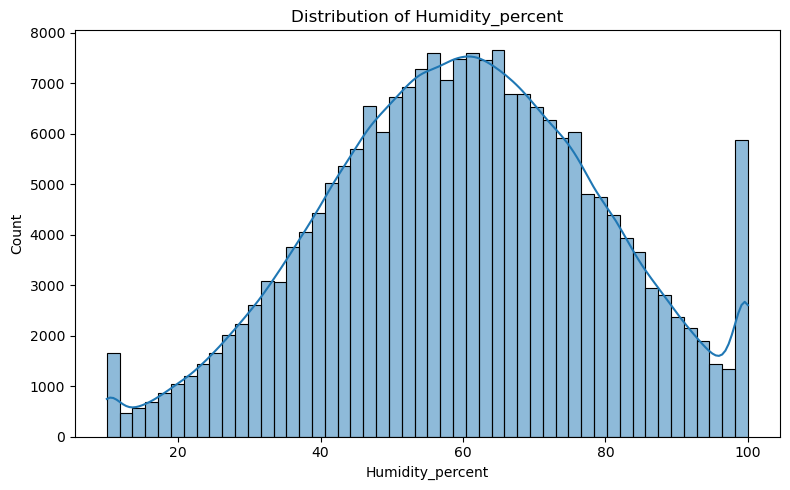

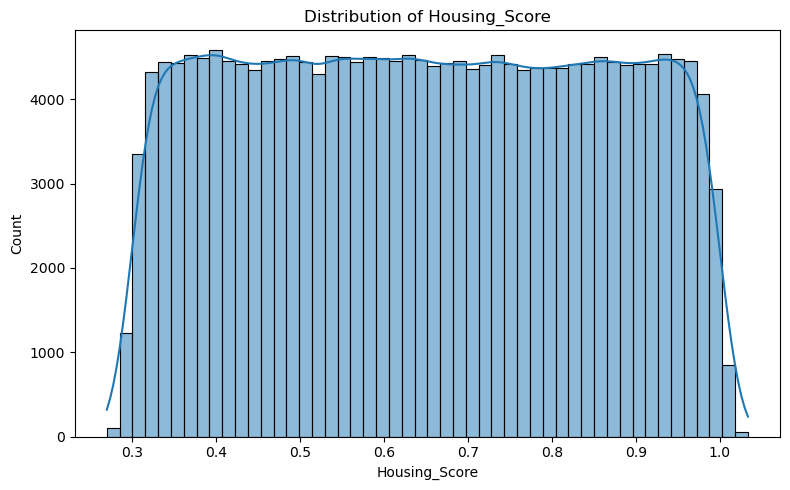

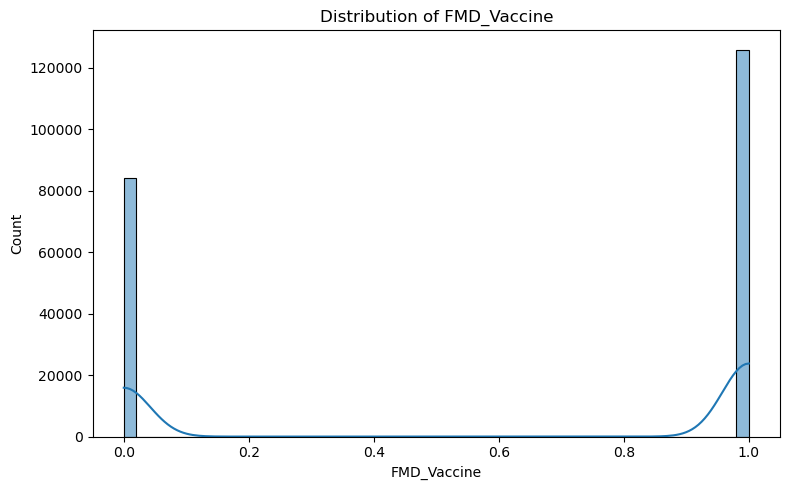

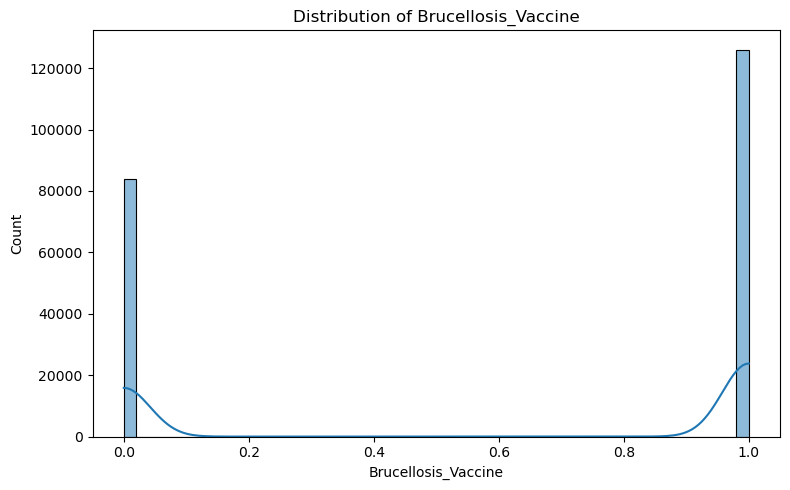

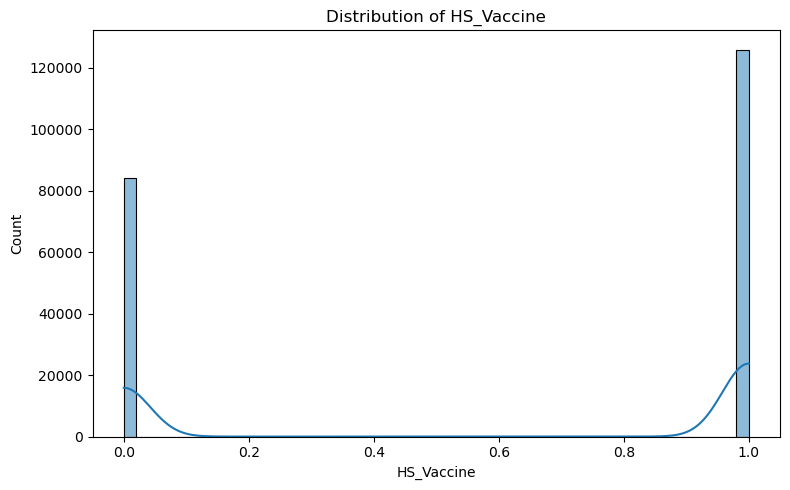

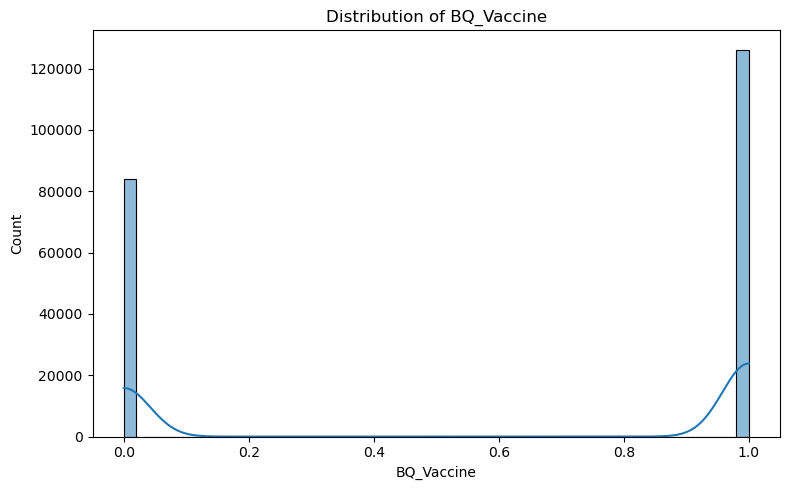

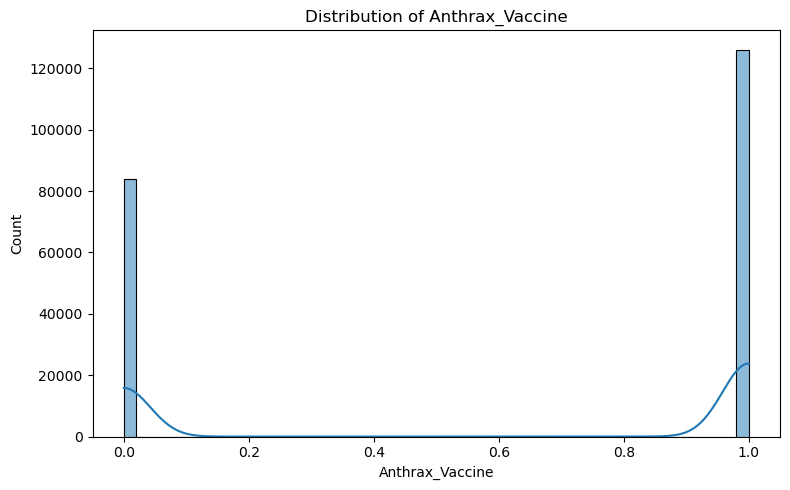

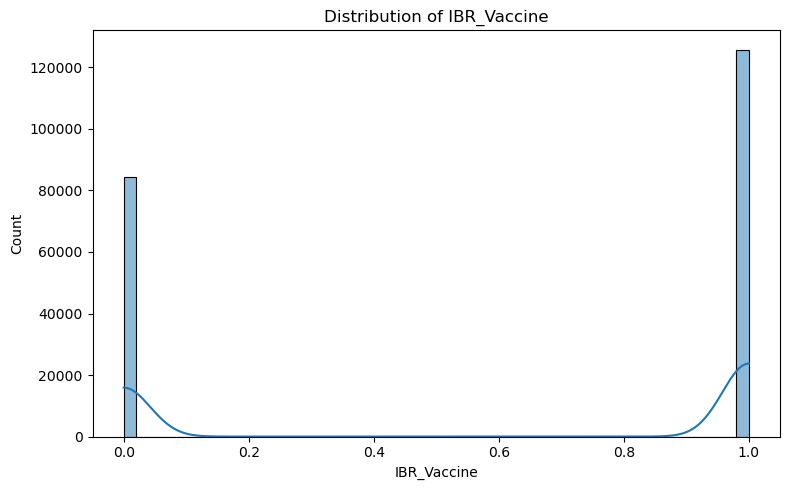

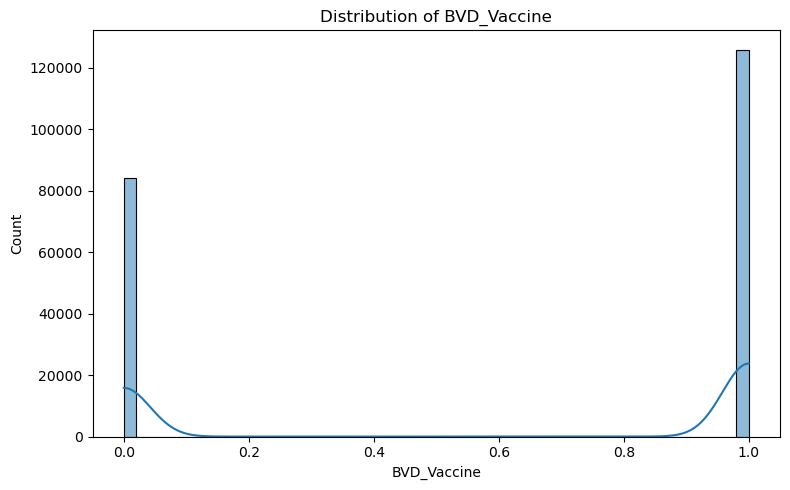

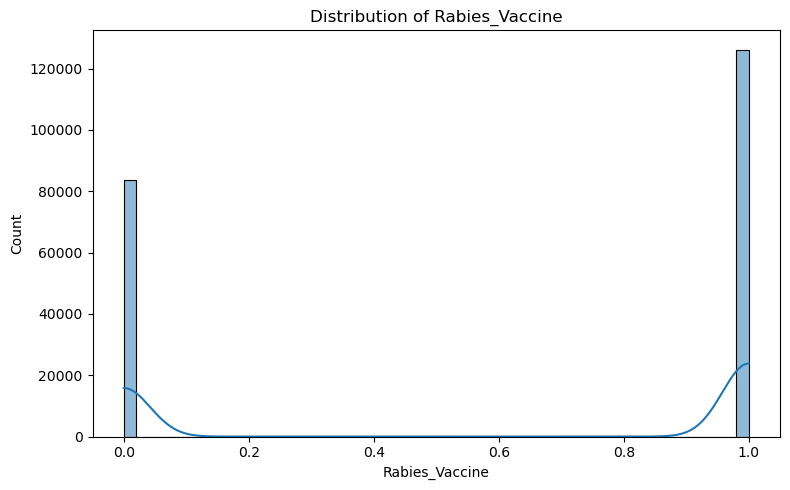

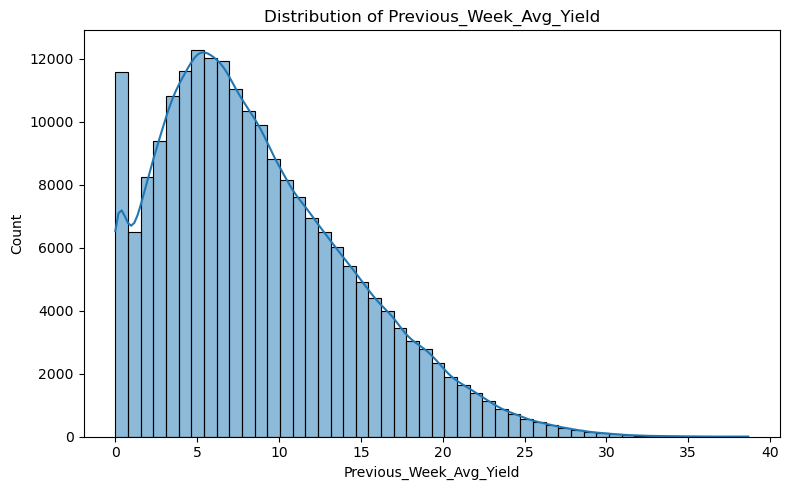

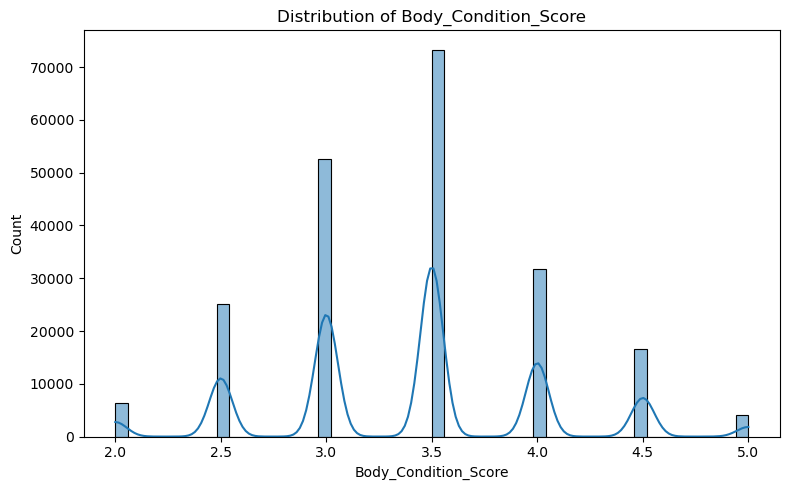

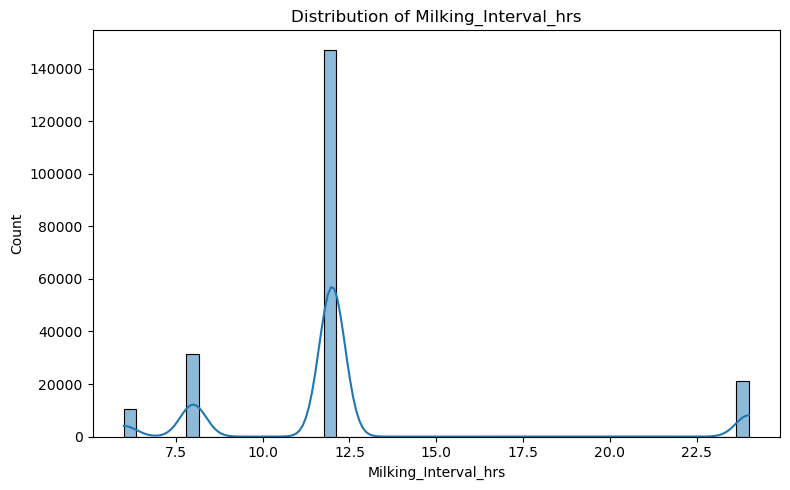

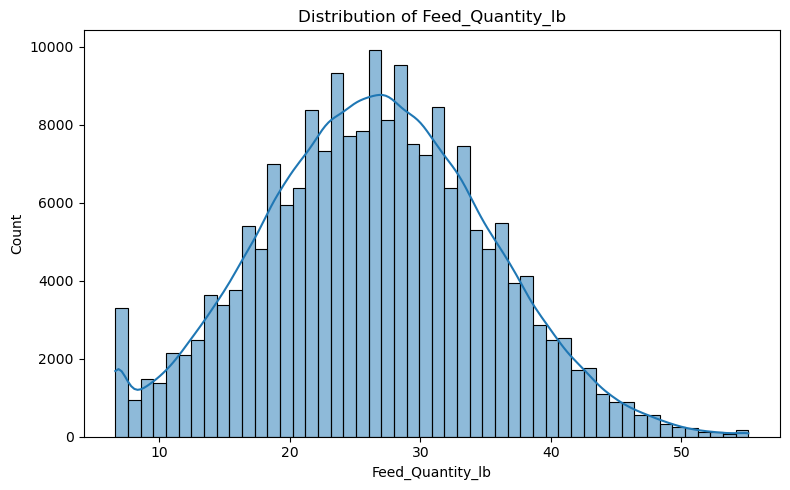

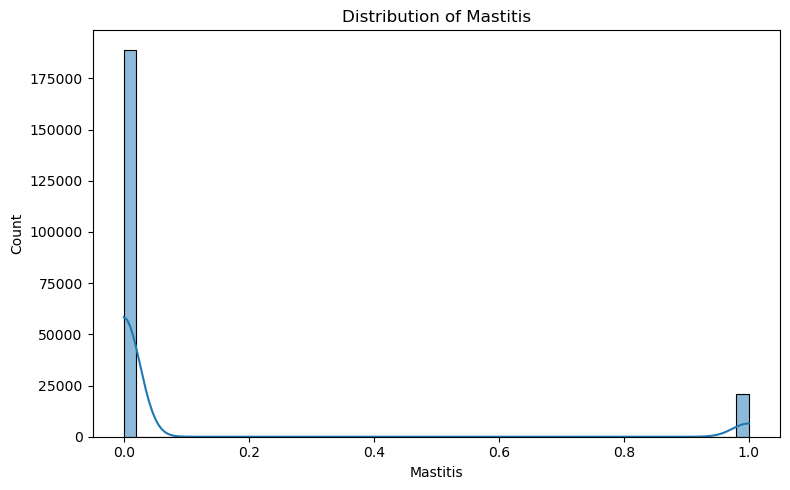

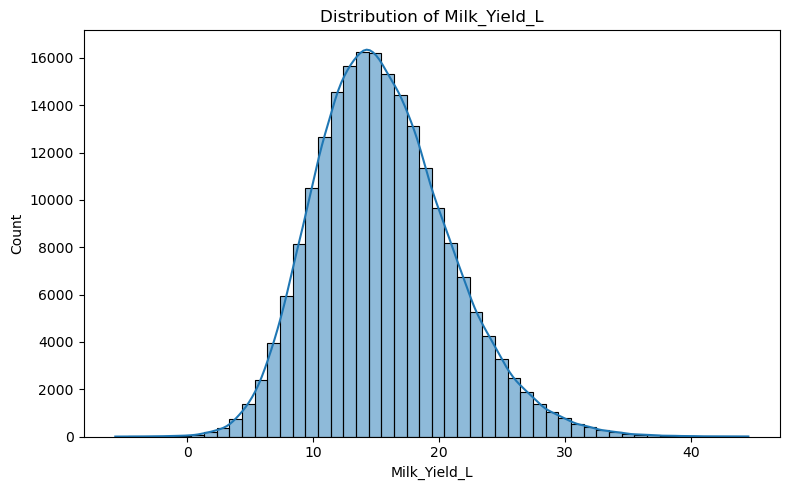

In [33]:
# Select numeric columns only
numeric_cols = train.select_dtypes(include=['number']).columns.tolist()

# Loop through all numeric columns and plot histograms with KDE
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(train[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


This further explores the distributions of the features by finding all the outliers for each numeric feature. 9 features have outliers, with the Milking_Interval_hrs and Mastitis features having the most significant number of outliers. Additionally, the majority of records with outliers only have one feature as an outlier, with a little more 9600 records having 2 or more outliers.

In [38]:
df = train
# numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Q1, Q3, IQR per numerical column
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

# boolean mask of outliers per column
outlier_mask = (df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))

# count of outliers per column (Series)
outlier_counts = outlier_mask.sum()

print(outlier_counts)

Age_Months                     0
Weight_kg                      0
Parity                         0
Days_in_Milk                   0
Feed_Quantity_kg             674
Feeding_Frequency              0
Water_Intake_L              1485
Walking_Distance_km          748
Grazing_Duration_hrs           0
Rumination_Time_hrs         2406
Resting_Hours                  0
Ambient_Temperature_C        196
Humidity_percent               0
Housing_Score                  0
FMD_Vaccine                    0
Brucellosis_Vaccine            0
HS_Vaccine                     0
BQ_Vaccine                     0
Anthrax_Vaccine                0
IBR_Vaccine                    0
BVD_Vaccine                    0
Rabies_Vaccine                 0
Previous_Week_Avg_Yield     2406
Body_Condition_Score           0
Milking_Interval_hrs       62833
Feed_Quantity_lb             698
Mastitis                   20995
Milk_Yield_L                2677
dtype: int64


In [40]:

# Select numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Dictionary to hold outlier boolean mask per column
outlier_masks = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_masks[col] = (df[col] < lower_bound) | (df[col] > upper_bound)

# Combine all masks to find rows with outliers in any column
combined_outliers = pd.concat(outlier_masks, axis=1).any(axis=1)

# Number of records with any outlier
num_any_outlier_records = combined_outliers.sum()
print(f"Number of records with at least one outlier: {num_any_outlier_records}")

# To check which records have outliers across multiple columns,
# sum the boolean masks row-wise
outlier_counts_per_record = pd.concat(outlier_masks, axis=1).sum(axis=1)

# Example: records with outliers in at least 2 columns
for i in range(9):
    records_multiple_outliers = df[outlier_counts_per_record == i]
    print(f"Number of records with outliers in {i} columns: {len(records_multiple_outliers)}")



Number of records with at least one outlier: 82665
Number of records with outliers in 0 columns: 127335
Number of records with outliers in 1 columns: 71695
Number of records with outliers in 2 columns: 9623
Number of records with outliers in 3 columns: 1216
Number of records with outliers in 4 columns: 127
Number of records with outliers in 5 columns: 3
Number of records with outliers in 6 columns: 1
Number of records with outliers in 7 columns: 0
Number of records with outliers in 8 columns: 0


### Categorical features 1.2.2

This looks at the value counts of the different categories for each catergorical variable. While looking at the value counts, we noticed that the breed had repreating categories that were recognized different due to spelling or formatting errors. Climate Zone, Feed Type, and Management System have a relatively even spread of records across all categories, Lactation Stage leans slightly towards the Mid Lactation Stage, and almost half of all all the records have a breed of Holstein. The imbalance in breed might introduce some minor bias, if patters from Holstein cows are applied on the other breeds of cows.

In [31]:
#categoricals
breed_data = train['Breed']
climate_data = train['Climate_Zone']
manage_data = train['Management_System']
lactate_data = train['Lactation_Stage']
feed_data = train['Feed_Type']
print(climate_data.value_counts(dropna = False))
print()
print(breed_data.value_counts(dropna = False))
print()
print(manage_data.value_counts(dropna = False))
print()
print(lactate_data.value_counts(dropna = False))
print()
print(feed_data.value_counts(dropna = False))

Climate_Zone
Temperate        35224
Tropical         35062
Mediterranean    34994
Arid             34954
Subtropical      34937
Continental      34829
Name: count, dtype: int64

Breed
Holstein        104775
Jersey           42183
Guernsey         31672
Brown Swiss      31155
Holstien           112
 Brown Swiss        57
Brown Swiss         46
Name: count, dtype: int64

Management_System
Intensive         42225
Pastoral          42126
Extensive         41973
Semi_Intensive    41906
Mixed             41770
Name: count, dtype: int64

Lactation_Stage
Mid      83895
Early    63203
Late     62902
Name: count, dtype: int64

Feed_Type
Dry_Fodder       26558
Pasture_Grass    26305
Crop_Residues    26278
Concentrates     26231
Mixed_Feed       26229
Green_Fodder     26198
Silage           26111
Hay              26090
Name: count, dtype: int64


### Unique Identifiers 1.2.3

When exploring the Farm_ID feature, we went in with the assumption that each unique farm would only be in one climate zone, since no farm is big enough to be present across multiple climate zones. However, we found that all farms have records from all 6 climate zones. However, it is not a perfectly even spread between the 6 zones for each farm, with each farm having a slightly different distribution of zones it has records for

In [49]:
# Group by Farm_ID and count unique Climate_Zones per farm
climate_zone_counts = test.groupby('Farm_ID')['Climate_Zone'].nunique()

# Display farms with more than one Climate_Zone associated
farms_multiple_zones = climate_zone_counts[climate_zone_counts > 1]

# print("Number of farms with multiple Climate Zones:", len(farms_multiple_zones))
print(climate_zone_counts)
num_unique_farms = test['Farm_ID'].nunique()
print("Number of unique farms:", num_unique_farms)
num_climates = test['Climate_Zone'].nunique()
print("Number of climate zones:", num_climates)

Farm_ID
FARM_0001    6
FARM_0002    6
FARM_0003    6
FARM_0004    6
FARM_0005    6
            ..
FARM_0996    6
FARM_0997    6
FARM_0998    6
FARM_0999    6
FARM_1000    6
Name: Climate_Zone, Length: 1000, dtype: int64
Number of unique farms: 1000
Number of climate zones: 6


In [52]:
distribution = df.groupby('Farm_ID')['Climate_Zone'].value_counts()
distribution

Farm_ID    Climate_Zone 
FARM_0001  Tropical         42
           Continental      37
           Subtropical      36
           Mediterranean    30
           Arid             27
                            ..
FARM_1000  Subtropical      42
           Continental      38
           Temperate        33
           Mediterranean    32
           Tropical         32
Name: count, Length: 6000, dtype: int64

# Data Cleaning Section 3

## 3.1 Summary of what worked

- **Removed invalid target values**  
  - Filtered out rows where `Milk_Yield_L < 0` for both CatBoost and XGBoost pipelines.

- **Standardized categorical text**  
  - Trimmed whitespace from `Breed` and corrected inconsistent spelling (`Holstien → Holstein`).

- **Imputed missing values**
  - `Housing_Score`: replaced missing values using the column median.
  - `Feed_Quantity_kg`: imputed per‐`Feed_Type` median to preserve context.
  - All remaining numeric fields: filled missing entries using column medians.
  - Median is safe to extremes in general.

- **Temporal feature extraction from `Date`**  
  - Parsed as datetime and derived features: `month`, `day`, `dayofweek`, `weekofyear`, `quarter`, and `is_weekend`; then removed `Date`.

- **Categorical feature handling**
  - CatBoost: preserved original categorical columns and passed them as native categorical features.
  - XGBoost: applied one-hot encoding after other feature engineering steps.

- **Farm identifier treatment**
  - Removed `Farm_ID` in CatBoost pipeline.
  - In XGBoost pipeline, applied fold-safe target encoding to convert `Farm_ID` into a numeric performance metric.

- **Outlier columns and IDs**
  - Dropped columns that uniquely identify samples (`Cattle_ID`) in both pipelines.


## 3.2 Summary of what did not work. 
- **Handeling Negative Values**
    - Taking an absolute value of those missing values made performance worse.
    - Since 55% of entries were negative, we treated this as a systemic issue rather than random noise. Positive values (mean 5.74, max 31.2) and negative values (mean −4.22, min −8.8) appeared to represent different behaviors, so taking the absolute value mixed distinct patterns. We attempted to separate them into different features, but this split did not improve performance.

# Exploratory Data Analysis 4

# Target Distribution 4.2

# Relationships with Key Features (or things we tried idk) 4.3

# Farm-Level Differences 4.4

In [ ]:
'''
Since we did farm clustering, show why and how, and also how it ended up being wrong in some way. Just talk about why we did this for example
'''

# Feature Engineering 5

### 5.1 Overview

We didn’t just feed the raw CSVs directly into our models. We iteratively engineered features, tested them with cross validation, and only kept transformations that were neutral or helpful for RMSE. Most experiments were guided by dairy domain reasoning, short and focused code changes, and immediate validation through average CV RMSE. If a feature block added noise or made the models worse, we removed it from the final pipeline.

A major early issue involved the **date column**. The raw file stored the date as an **object** rather than a true `datetime`. Because our preprocessing step converted all object columns into categoricals, the date was being treated as thousands of unrelated categories instead of a temporal variable. This caused instability and strange model behavior. Converting the date into a proper `datetime` type and extracting structured components — such as **year**, **month**, **day**, and **day of week** — immediately fixed this instability and made the models behave far more consistently. This correction became an important foundation for every later feature block.


### 5.2 Core CatBoost Feature Engineering

For CatBoost, we built features incrementally, keeping only the pieces that consistently helped or at least did not hurt CV RMSE.

**Kept features and steps included:**
- Biologically meaningful ratios:
  - `Feed_per_kg_bw`
  - Temperature-Humidity Index (THI) for heat stress  
  - `Walk_per_graze` (distance walked per grazing hour)
- Explicitly labeling categorical columns so CatBoost uses its native encoding properly.
- Dropping 74 rows with **negative** `Milk_Yield_L` labels, which are physically impossible and were hurting training.
- Lactation curve features such as:
  - `is_peak_lactation`, `is_early_lactation`, `is_late_lactation`
  - `dim_squared`, `dim_cubed`, `dim_log`
  - `dim_parity`

These changes moved CatBoost from about **4.114 RMSE → ~4.108**, with dropping negative labels being the biggest single improvement.


### 5.3 CatBoost Ideas We Tested But Did Not Keep

We experimented with several larger interaction blocks that ended up hurting RMSE:

- Additional efficiency ratios (`water_per_weight`, `age_parity_ratio`, `age_parity_product`, etc.)
- Activity combinations (`total_activity`, `rest_activity_ratio`)
- More complicated temperature-humidity interactions
- Bundled vaccine indicators or sums

Most of these made RMSE worse or added noise, so we removed them and kept only the simpler, more stable features.


### 5.4 Rumination and Farm-Level Statistics

We explored multiple strategies to handle the unusual rumination values and farm-level context:

- Making all rumination values positive made the model worse.
- Splitting rumination into “positive mode” and “negative mode” plus flags was more logical but still not better in practice.
- Treating negative rumination values as **missing (NaN)** was neutral and aligned with the idea of faulty sensors.
- Farm-level stats — farm mean and standard deviation for predictors like:
  - `Weight_kg`, `Feed_Quantity_kg`, `Water_Intake_L`, `Age_Months`
  - `Days_in_Milk`, `Ambient_Temperature_C`

These features describe farm environment without leaking targets.

In the final pipeline, we used a simpler rumination approach and a **lighter** set of farm statistics to avoid overfitting.


### 5.5 Peer-Relative Features and Clustering

We explored two types of contextual features:

#### 1. Peer-relative features
For each farm, we compared each cow to its farm peers via:
- **Difference** features (e.g., `Weight_kg_vs_farm_diff`)
- **Ratio** features (e.g., `Weight_kg_vs_farm_ratio`)

These were meant to capture whether a cow is above or below typical farm-level baselines.

#### 2. Farm clustering
We tried clustering farms with KMeans and assigning each farm a cluster label.
However, since train and test were clustered separately, the IDs did not align, which created anti-signal.  
Once we realized this, we removed `Farm_Cluster`.

Peer-relative features were conceptually strong but did not outperform simpler normalized farm stats, so we relied mainly on the latter.


### 5.6 XGBoost Feature Engineering

We also maintained an XGBoost pipeline to complement CatBoost and use as a second model family.  
XGBoost was very sensitive to early feature blocks, especially before we correctly processed the **date column**, which had been treated as a high-cardinality categorical. Once we converted the date to `datetime` and stabilized the feature set, **we returned to XGBoost**, and it became much more consistent.

We engineered and tested:

- Age and parity transforms (`Age_Years`, `Age_Years2`, `Parity2`, `Age_x_Parity`)
- Nonlinear `Days_in_Milk` transforms (`DIM_log`)
- Efficiency ratios (`Feed_per_kgBW`, `Water_per_kgBW`, `PrevYield_per_Feed`)
- THI and simple vaccine summaries (`Vax_Sum`)
- Farm-delta and cohort-relative features
- A large biological block of lactation and health indicators

The most consistently helpful additions were:
- Simple **parity categories**
- **Farm-normalized predictors**
- A **Vax_Sum + farm-delta** combination


### 5.7 Encodings and Dimensionality Reduction

Instead of PCA, we used targeted supervised encodings and structured normalization:

**Tried:**
- Farm-normalized predictors (subtracting or standardizing by farm averages)
- K-Fold target encoding with out-of-fold means
- Frequency encoding for large categoricals such as `Breed`

Target encoding usually hurt XGBoost and didn’t help CatBoost, so we removed it.  
Farm-normalized predictors and simple parity categories were the most reliable encodings.

We considered PCA, but tree models handle moderate dimensionality well and PCA reduces interpretability.  
Targeted feature selection and selective dropping worked better for our dataset.


### 5.8 Summary

Across all iterations, the most important feature engineering wins were:

- **Fixing the date column** by converting it from object → datetime  
- **Dropping physically impossible negative labels**
- **Meaningful biological ratios and farm-normalized predictors**
- **Lightweight farm statistics**
- **Avoiding oversized interaction blocks**
- **Revisiting XGBoost only after stabilizing the feature space**

These steps led to a stable, interpretable, and high-performing feature set that consistently improved CatBoost and allowed XGBoost to be evaluated fairly.


### 5.9 Model Feedback During Feature Engineering

Our modeling work during feature engineering focused on using CatBoost, LightGBM, and XGBoost as feedback tools rather than finalized models. We applied the same preprocessing pipeline and cross validation splits to each model to understand how different engineered features affected stability, signal strength, and overall RMSE.

Key observations:

- CatBoost consistently responded the best to our engineered features, making it a reliable indicator of whether a new feature block was helpful or harmful.
- LightGBM performed reasonably but tended to lose performance once the feature space became more complex.
- XGBoost struggled early on—especially before fixing the date column—but improved significantly after the feature pipeline was stabilized and we revisited it near the end.

We also monitored feature interactions through multiple CatBoost runs, tracking how RMSE changed as new biological ratios, farm-normalized predictors, and date-derived components were added. This allowed us to keep only the transformations that consistently improved model behavior.

Overall, this model feedback loop was essential during feature engineering. It helped confirm which features were robust across different frameworks and guided the final feature set before moving on to full modeling and tuned ensembles.


# Baseline Model (Modeling Approach) 6

In [ ]:
'''
Here we show the baseline model we used w/ default ish paramaters. Show it, train it, run it, no optuna, show fold RMSEs, Average CV RMSEs, and explain what it's doing for us and anything else we can add to make this section full
'''

## 5. Modeling Approach & Experiments
In this section we describe our full modeling process starting from our base model, from how we tuned and compared, the different experiments, and how we eventually arrived and stuck with our final CatBoost ensemble with blending. The goal was not just to get a good leaderboard score but also explore model decisions and what needed to take place for things to improve.


### 5.1 Hyperparameter Tuning with Optuna

After we selected CatBoost as our main model and saw that additional feature engineering was giving only small gains compared to the numerous experiments we tried with features, we focused on **hyperparameter tuning** to squeeze out as much performance as possible from our single best strongest learner.

We actually ran **two separate Optuna studies** for CatBoost:

- **Run 1 – 40 trials (our best hyperparameters)**
- **Run 2 – 80 trials with an expanded search space**

Both runs used the same 5-fold CV split and the same preprocessing pipeline, so their RMSEs are directly comparable.


#### 5.1.1 First Optuna Run (40 trials)

In the first study, we tuned the “core” CatBoost hyperparameters:

- `depth` (5–7)
- `learning_rate` (0.02–0.04)
- `l2_leaf_reg` (L2 regularization)
- `subsample` (row subsampling)
- `random_strength` (randomness in split selection)
- `bagging_temperature` (controls how aggressive the sampling is)
- `n_estimators` was capped at 3000, with early stopping on each fold

For each trial, the objective function trained on 4 folds and validated on the 5th, and we minimized the **mean 5-fold RMSE**.

- **Best CV RMSE (Run 1):** ≈ **4.10639**
- **Best hyperparameters (Run 1):**  
  - `depth = 6`  
  - `learning_rate ≈ 0.0229`  
  - `l2_leaf_reg ≈ 4.01`  
  - `subsample ≈ 0.847`  
  - `random_strength ≈ 0.73`  
  - `bagging_temperature ≈ 0.46`

When we retrained a 5-fold CV ensemble with these parameters, we got:

- **Final 5-fold CV RMSE:** ≈ **4.1064**  
- **Best iterations per fold:** around **1,000–1,150 trees**, with an average of ~**1,094** boosting rounds

This first Optuna run gave us the **strongest configuration** we found and became the base for our ensembling and blending experiments.


#### (Full code + full output available in `felipe_model.ipynb`.)

In [ ]:
# Showing just Optuna search and final model training with best params, not the initial baseline model as it remains unchanged from previous version

# Optuna hyperparameter search (5-fold CV)
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 5, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.04),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 7.0),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "random_strength": trial.suggest_float("random_strength", 0.5, 5.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
    }

    fold_rmses = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostRegressor(
            loss_function="RMSE",
            n_estimators=3000, # big cap, rely on early stopping
            early_stopping_rounds=100,
            random_seed=42,
            thread_count=4,
            verbose=False, # keep Optuna runs quiet
            **params
        )

        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            cat_features=cat_features, # using column names
            verbose=False
        )

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        fold_rmses.append(rmse)

    mean_rmse = float(np.mean(fold_rmses))
    return mean_rmse

# Optuna study
N_TRIALS = 40  

print("\nStarting Optuna hyperparameter search...")
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=N_TRIALS, n_jobs=2, show_progress_bar=True)

best_params = study.best_params
best_cv_rmse = study.best_value

print("\nOptuna search complete.")
print("Best CV RMSE from Optuna:", best_cv_rmse)
print("Best params:", best_params)

# Final 5-fold CV ensemble with best_params
cv_models = []
fold_rmses = []
fold_best_iters = []

print("\nTraining final 5-fold ensemble with best_params...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    print(f"\n----- Final CV Fold {fold} -----")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # use SAME seed as Optuna for consistency
    model = CatBoostRegressor(
        loss_function="RMSE",
        n_estimators=3000,
        early_stopping_rounds=100,
        random_seed=42,
        thread_count=4,
        verbose=False,
        **best_params
    )

    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        verbose=False
    )

    preds_val = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds_val))
    best_iter = model.get_best_iteration()

    print(f"Fold {fold} RMSE: {rmse:.4f}, best_iter={best_iter}")

    fold_rmses.append(rmse)
    fold_best_iters.append(best_iter)
    cv_models.append(model)

final_cv_rmse = float(np.mean(fold_rmses))
print("\n===============================")
print(f"Final 5-fold ensemble CV RMSE: {final_cv_rmse:.4f}")
print("Fold RMSEs:", fold_rmses)
print("Best iters:", fold_best_iters)

# sanity check vs Optuna's own CV
if final_cv_rmse > best_cv_rmse + 0.001:
    print("WARNING: Final CV RMSE is worse than Optuna's best!")
    print(f"Optuna best: {best_cv_rmse:.4f}, Final CV: {final_cv_rmse:.4f}")
    print("This might indicate some instability / differences in folds.")
print("===============================")

# CV-ensemble predictions on test_df
cv_test_preds = np.zeros(len(test_df), dtype=float)

for model in cv_models:
    cv_test_preds += model.predict(test_df)

cv_test_preds /= len(cv_models)
sub_cv = pd.DataFrame({
    id_col: test[id_col],
    target: cv_test_preds
})

save_submission(sub_cv, run_name="felipe_catboost_optuna_cv_only")
print("Saved CV-only submission: felipe_catboost_optuna_cv_only")

Optuna search complete.

Best CV RMSE from Optuna: 4.106391174299612

Best params: {'depth': 6, 'learning_rate': 0.022872270426979868, 'l2_leaf_reg': 4.014881862534349, 'subsample': 0.847236734294946, 'random_strength': 0.731107887920747, 'bagging_temperature': 0.4635035306948895}


Training final 5-fold ensemble with best_params...

----- Final CV Fold 1 -----
Fold 1 RMSE: 4.1070, best_iter=1157

----- Final CV Fold 2 -----
Fold 2 RMSE: 4.1002, best_iter=1127

----- Final CV Fold 3 -----
Fold 3 RMSE: 4.1201, best_iter=1093

----- Final CV Fold 4 -----
Fold 4 RMSE: 4.1063, best_iter=1094

----- Final CV Fold 5 -----
Fold 5 RMSE: 4.0984, best_iter=999

Final 5-fold ensemble CV RMSE: 4.1064

Fold RMSEs: [np.float64(4.106956550228758), np.float64(4.100151472353626), np.float64(4.120099489769896), np.float64(4.106327628323443), np.float64(4.0984207308223395)]

Best iters: [1157, 1127, 1093, 1094, 999]

Saved submission -> /Users/felipebenitez/ML-Project/submissions/felipe_catboost_optuna_cv_only__2025-11-17__20-14-39.csv

Saved CV-only submission: felipe_catboost_optuna_cv_only

#### 5.1.2 Second Optuna Run (80 trials, expanded space)

Later, we ran a **second Optuna study with 80 trials**, this time expanding the search space to include more tree-shape and regularization parameters:

- New hyperparameters included:
  - `border_count` (number of candidate split points)
  - `min_data_in_leaf` (minimum samples per leaf)
  - `bootstrap_type = "Bayesian"` with tuned `bagging_temperature`
- We continued to tune:
  - `learning_rate`
  - `l2_leaf_reg`
  - `random_strength`

Again we minimized the mean 5-fold CV RMSE.

- **Best CV RMSE (Run 2):** ≈ **4.10642**

So the second run got basically the **same performance**, but **very slightly worse** than Run 1 (difference on the order of 0.00003 in RMSE, which is completely negligible and likely within CV noise).

The best hyperparameters from Run 2 looked like:

- `depth = 6` (fixed)
- `border_count = 128`
- `learning_rate ≈ 0.0150`
- `l2_leaf_reg ≈ 1.94`
- `random_strength ≈ 0.30`
- `bagging_temperature ≈ 2.16`
- `min_data_in_leaf = 44`
- `bootstrap_type = "Bayesian"`
- `grow_policy = "SymmetricTree"`

When we retrained with these parameters:

- **Final 5-fold CV RMSE:** again ≈ **4.1064**
- **Best iterations per fold:** much **larger**, around **1,700–2,100 trees**, with an average of ~**1,883** boosting rounds

#### (Full code + full output available in `felipe_model.ipynb`.)

In [ ]:
fixed_params = {
    "depth": 6,
    "bootstrap_type": "Bayesian",
    "grow_policy": "SymmetricTree",
}

# Optuna hyperparameter search (5-fold CV)
def objective(trial):
    tuned_params = {
        # QUANTIZATION
        # 128 is a sweet spot for noisy data (vs default 254)
        "border_count": trial.suggest_categorical("border_count", [128, 254]),
        # REGULARIZATION
        "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.06),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 0.1, 8.0),
        # BAYESIAN BAGGING (Replaces subsample)
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 3.0),
        # COLUMN SAMPLING
        "rsm": trial.suggest_float("rsm", 0.7, 1.0),  # colsample_bylevel
        # OVERFITTING CONTROL
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 80),
    }

    params = {**fixed_params, **tuned_params}

    fold_rmses = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostRegressor(
            loss_function="RMSE",
            n_estimators=3000, # big cap, rely on early stopping
            early_stopping_rounds=100,
            random_seed=42,
            use_best_model=True,
            thread_count=4,
            verbose=False, # keep Optuna runs quiet
            **params
        )

        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            cat_features=cat_features, # using column names
            verbose=False
        )

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        fold_rmses.append(rmse)

    mean_rmse = float(np.mean(fold_rmses))
    return mean_rmse

N_TRIALS = 80  

print("\nStarting Optuna hyperparameter search...")
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=N_TRIALS, n_jobs=2, show_progress_bar=True)

best_params = study.best_params
best_cv_rmse = study.best_value

final_params = {**fixed_params, **best_params}

print("\nOptuna search complete.")
print("Best CV RMSE from Optuna:", best_cv_rmse)
print("Best params:", best_params)
print("Final params used for training:", final_params)

import json
with open("catboost_best_params.json", "w") as f:
    json.dump(final_params, f, indent=2)
print("Saved best params to catboost_best_params.json")


# Final 5-fold CV ensemble with best_params
cv_models = []
fold_rmses = []
fold_best_iters = []

print("\nTraining final 5-fold ensemble with best_params...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    print(f"\n----- Final CV Fold {fold} -----")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # use SAME seed as Optuna for consistency
    model = CatBoostRegressor(
        loss_function="RMSE",
        n_estimators=3000,
        early_stopping_rounds=100,
        use_best_model=True,
        random_seed=42,
        thread_count=4,
        verbose=False,
        **final_params
    )

    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        verbose=False
    )

    preds_val = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds_val))
    best_iter = model.get_best_iteration()

    print(f"Fold {fold} RMSE: {rmse:.4f}, best_iter={best_iter}")

    fold_rmses.append(rmse)
    fold_best_iters.append(best_iter)
    cv_models.append(model)

final_cv_rmse = float(np.mean(fold_rmses))
print("\n===============================")
print(f"Final 5-fold ensemble CV RMSE: {final_cv_rmse:.4f}")
print("Fold RMSEs:", fold_rmses)
print("Best iters:", fold_best_iters)

# sanity check vs Optuna's own CV
if final_cv_rmse > best_cv_rmse + 0.001:
    print("WARNING: Final CV RMSE is worse than Optuna's best!")
    print(f"Optuna best: {best_cv_rmse:.4f}, Final CV: {final_cv_rmse:.4f}")
    print("This might indicate some instability / differences in folds.")
print("===============================")

# CV-ensemble predictions on test_df

cv_test_preds = np.zeros(len(test_df), dtype=float)

for model in cv_models:
    cv_test_preds += model.predict(test_df)

cv_test_preds /= len(cv_models)
sub_cv = pd.DataFrame({
    id_col: test[id_col],
    target: cv_test_preds
})

save_submission(sub_cv, run_name="felipe_catboost_optuna_cv_only")
print("Saved CV-only submission: felipe_catboost_optuna_cv_only")

Optuna search complete.

Best CV RMSE from Optuna: 4.106420555491676

Best params: {'border_count': 128, 'learning_rate': 0.015001219012030928, 'l2_leaf_reg': 1.9410139722523063, 'random_strength': 0.2958486733531681, 'bagging_temperature': 2.161101900330739, 'min_data_in_leaf': 44}
Final params used for training: {'depth': 6, 'bootstrap_type': 'Bayesian', 'grow_policy': 'SymmetricTree', 'border_count': 128, 'learning_rate': 0.015001219012030928, 'l2_leaf_reg': 1.9410139722523063, 'random_strength': 0.2958486733531681, 'bagging_temperature': 2.161101900330739, 'min_data_in_leaf': 44}

Saved best params to catboost_best_params.json

Training final 5-fold ensemble with best_params...

----- Final CV Fold 1 -----
Fold 1 RMSE: 4.1075, best_iter=1913

----- Final CV Fold 2 -----
Fold 2 RMSE: 4.0993, best_iter=2164

----- Final CV Fold 3 -----
Fold 3 RMSE: 4.1205, best_iter=1676

----- Final CV Fold 4 -----
Fold 4 RMSE: 4.1063, best_iter=1735

----- Final CV Fold 5 -----
Fold 5 RMSE: 4.0985, best_iter=1931


Final 5-fold ensemble CV RMSE: 4.1064

Fold RMSEs: [np.float64(4.107491747188065), np.float64(4.09931832448274), np.float64(4.120481129392497), np.float64(4.10632954798902), np.float64(4.098482019336163)]

Best iters: [1913, 2164, 1676, 1735, 1931]


Saved submission -> c:\Users\Edwin\cs363M\project\ML-Project\src\submissions\felipe_catboost_optuna_cv_only__2025-11-23__03-39-41.csv

Saved CV-only submission: felipe_catboost_optuna_cv_only

#### 5.1.3 Interpreting the differences between the two runs

Even though Run 2 searched a bigger space and ran for more trials, it did **not** improve RMSE beyond Run 1. The difference in parameters tells us why:

- **Learning rate**
  - Run 1: `learning_rate ≈ 0.0229`  
  - Run 2: `learning_rate ≈ 0.0150` (smaller)  
  → A smaller learning rate usually needs **more trees** (which we see from the best iterations) and can make training slower without guaranteeing a better optimum. In our case, the lower learning rate just led to **more boosting rounds** with essentially the same RMSE.

- **L2 regularization (`l2_leaf_reg`)**
  - Run 1: `≈ 4.01` (stronger regularization)  
  - Run 2: `≈ 1.94` (weaker regularization)  
  → Run 2 allowed individual leaves to fit slightly more aggressively, but we also increased bagging and min leaf size. These trade-offs roughly canceled out, leading again to almost identical performance.

- **Bagging behavior**
  - Run 1: `bagging_temperature ≈ 0.46` (milder stochasticity)  
  - Run 2: `bagging_temperature ≈ 2.16` + `bootstrap_type = "Bayesian"`  
  → Run 2 used **much more aggressive Bayesian-style bagging**, injecting more randomness into which data points each tree sees. This can help reduce overfitting, but because our dataset is large and our Run 1 model was already well-regularized, the extra randomness did not produce a clear RMSE gain.

- **Tree shape and leaf constraints**
  - Run 1: used CatBoost’s default `border_count` and leaf constraints  
  - Run 2: explicitly tuned  
    - `border_count = 128` (fewer split candidates than 254, slightly simpler trees)  
    - `min_data_in_leaf = 44` (prevents tiny leaves, smooths predictions)  
  → These changes **regularize** the tree structure: they avoid overly fine splits and tiny leaves. That can improve generalization if the model is overfitting, but in our case the Run 1 configuration was already near the bias-variance sweet spot, so the extra constraints did not translate into a meaningful RMSE improvement.

Overall, the second Optuna run **validated** that we were already sitting in a very flat optimum: many slightly different hyperparameter combinations (with different regularization/bagging trade-offs) all land around RMSE ≈ 4.1064.

Because **Run 1** achieved the **lowest CV RMSE** and used a slightly simpler set of hyperparameters, we treated it as our **primary “best” configuration** and used it as the base for our CatBoost ensembles and blending experiments. The second run mainly served as a robustness check and showed that even after 80 more trials and a richer search space, we could not significantly beat our original tuned model.

#### 5.1.4 XGBoost Hyperparameter Tuning with Optuna (500 trials)

To build a strong **second model** for ensembling, we also ran a large Optuna study for **XGBoost** with **500 trials**, using the same 5-fold CV and essentially the same preprocessing pipeline as CatBoost:

- cleaned and engineered features (date features, farm clustering, vaccine sum, parity indicators),
- applied **fold-safe target encoding** on `Farm_ID` and created farm-delta features (`Prev_vs_Farm`, `Prev_over_Farm`),
- one-hot encoded categorical variables **within each fold** and aligned train/validation columns to avoid leakage.

Each Optuna trial trained a 5-fold CV XGBoost regressor (with early stopping) and minimized the **mean 5-fold RMSE**.

The search space covered both **tree structure** and **regularization**:

- Tree growth and structure:
  - `grow_policy ∈ {depthwise, lossguide}`
  - `max_depth` (0–12, depending on `grow_policy`)
  - `max_leaves` (16–256)
  - `max_bin ∈ {128, 256, 512}`
- Learning and sampling:
  - `learning_rate ∈ [0.005, 0.1]` (log-scaled)
  - `subsample ∈ [0.5, 0.95]`
  - `colsample_bytree`, `colsample_bylevel`, `colsample_bynode ∈ [0.5, 0.95]`
- Regularization:
  - `gamma ∈ [1e-4, 10]` (log-scaled)
  - `reg_alpha ∈ [1e-4, 50]` (log-scaled)
  - `reg_lambda ∈ [1e-3, 50]` (log-scaled)

The **best trial** out of 500 achieved a **mean CV RMSE ≈ 4.1151** with a relatively shallow but strongly regularized configuration:

- `grow_policy = "depthwise"`
- `max_depth = 4`
- `max_bin = 128`
- `learning_rate ≈ 0.00681`
- `max_leaves ≈ 171`
- `min_child_weight ≈ 2.88`
- `subsample ≈ 0.529`
- `colsample_bytree ≈ 0.528`
- `colsample_bylevel ≈ 0.920`
- `colsample_bynode ≈ 0.941`
- `gamma ≈ 0.632`
- `reg_alpha ≈ 49.96`
- `reg_lambda ≈ 35.12`

Using these tuned hyperparameters, we then retrained:

- A **5-fold CV ensemble**, which achieved  
  - **Final 5-fold CV RMSE:** ≈ **4.1151**  
  - Fold RMSEs in the range **4.106–4.127**, with best iteration counts around **2,800–3,300** trees per fold.
- A **full-data multi-seed ensemble**, where we:
  - re-fit on all training data for ~the average best-iteration from CV,
  - used multiple random seeds (e.g., 42, 100, 200, 300, 400),
  - averaged their predictions to produce our final XGBoost test predictions.

Even after this large 500-trial search, tuned XGBoost remained slightly weaker than our best CatBoost configuration (≈ **4.115** vs. ≈ **4.106** RMSE). However, because its error pattern was different, this XGBoost model was still **valuable as a complementary learner**, and we used its OOF and test predictions in our **stacking / blending experiments** described in Section 6.2.

#### (Full code + full output available in `felipe_model.ipynb`.)

In [ ]:
# Optuna Tuning for XGBoost (500 Trials + Advanced Space)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if grow_policy == "lossguide":
        max_depth = trial.suggest_int("max_depth", 0, 10)
    else:
        max_depth = trial.suggest_int("max_depth", 3, 12)

    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "seed": 42,
        "nthread": 4,
        "grow_policy": grow_policy,

        "max_bin": trial.suggest_categorical("max_bin", [128, 256, 512]),

        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),

        "max_depth": max_depth,
        "max_leaves": trial.suggest_int("max_leaves", 16, 256),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 20.0, log=True),

        "subsample": trial.suggest_float("subsample", 0.5, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.95),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.95),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 0.95),

        "gamma": trial.suggest_float("gamma", 1e-4, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 50.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 50.0, log=True),
    }

    fold_rmses = []

    for tr_idx, val_idx in kf.split(X_base):
        X_tr_base = X_base.iloc[tr_idx]
        X_val_base = X_base.iloc[val_idx]
        y_tr = y.iloc[tr_idx]
        y_val = y.iloc[val_idx]

        # fold-safe TE
        X_tr, X_val, _ = fold_target_encode(X_tr_base, y_tr, X_val_base, test_base)
        X_tr  = add_farm_deltas(X_tr)
        X_val = add_farm_deltas(X_val)

        # OHE + align within fold
        X_tr  = pd.get_dummies(X_tr, drop_first=False)
        X_val = pd.get_dummies(X_val, drop_first=False)
        X_tr, X_val = X_tr.align(X_val, join="left", axis=1, fill_value=0)

        dtr  = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(
            params,
            dtr,
            num_boost_round=3000,
            evals=[(dval, "val")],
            early_stopping_rounds=100,
            verbose_eval=False
        )

        best_iter = model.best_iteration if hasattr(model, "best_iteration") else 2999
        preds = model.predict(dval, iteration_range=(0, best_iter + 1))
        fold_rmses.append(np.sqrt(mean_squared_error(y_val, preds)))

    return float(np.mean(fold_rmses))


N_TRIALS = 500
print(f"\nStarting Diamond-Tier XGBoost Optuna ({N_TRIALS} trials)...")

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=N_TRIALS, n_jobs=2, show_progress_bar=True)

best_params = study.best_params
best_params.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "seed": 42,
    "nthread": 4
})
final_params = dict(best_params)

print("\nBest Params:", best_params)
with open("xgboost_diamond_params.json", "w") as f:
    json.dump(best_params, f, indent=4)
print("Saved best params to xgboost_diamond_params.json")

# Build GLOBAL feature templates to prevent mismatch
X_full_enc, _, test_full_enc = fold_target_encode(X_base, y, X_base.iloc[:1], test_base)
X_full_enc  = add_farm_deltas(X_full_enc)
test_full_enc = add_farm_deltas(test_full_enc)

X_full_enc = pd.get_dummies(X_full_enc, drop_first=False)
test_full_enc = pd.get_dummies(test_full_enc, drop_first=False)
X_full_enc, test_full_enc = X_full_enc.align(test_full_enc, join="left", axis=1, fill_value=0)

GLOBAL_COLS = X_full_enc.columns.tolist()

# Final 5-fold CV ensemble with tuned params
cv_models = []
fold_rmses = []
fold_best_iters = []
cv_oof = np.zeros(len(X_base), dtype=float)

num_boost_round = 6000
early_stop = 120

print("\nTraining final XGB 5-fold ensemble...")

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_base), 1):
    print(f"\n----- Final Fold {fold} -----")
    X_tr_base = X_base.iloc[tr_idx]
    X_val_base = X_base.iloc[val_idx]
    y_tr = y.iloc[tr_idx]
    y_val = y.iloc[val_idx]

    X_tr, X_val, _ = fold_target_encode(X_tr_base, y_tr, X_val_base, test_base)
    X_tr  = add_farm_deltas(X_tr)
    X_val = add_farm_deltas(X_val)

    X_tr  = pd.get_dummies(X_tr, drop_first=False).reindex(columns=GLOBAL_COLS, fill_value=0)
    X_val = pd.get_dummies(X_val, drop_first=False).reindex(columns=GLOBAL_COLS, fill_value=0)

    dtr  = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params=final_params,
        dtrain=dtr,
        num_boost_round=num_boost_round,
        evals=[(dval, "val")],
        early_stopping_rounds=early_stop,
        verbose_eval=False
    )

    best_iter = model.best_iteration if hasattr(model, "best_iteration") else num_boost_round - 1
    preds_val = model.predict(dval, iteration_range=(0, best_iter + 1))

    rmse = float(np.sqrt(mean_squared_error(y_val, preds_val)))
    print(f"Fold {fold} RMSE: {rmse:.6f}, best_iter={best_iter}")

    fold_rmses.append(rmse)
    fold_best_iters.append(best_iter)
    cv_models.append(model)
    cv_oof[val_idx] = preds_val

final_cv_rmse = float(np.sqrt(mean_squared_error(y, cv_oof)))
print("\n===========================")
print(f"Final CV RMSE: {final_cv_rmse:.6f}")
print("Fold RMSEs:", fold_rmses)
print("Best iters:", fold_best_iters)
print("===========================\n")


# CV-ensemble predictions on test
dtest = xgb.DMatrix(test_full_enc)

cv_test_preds = np.zeros(len(test_full_enc), dtype=float)
for m in cv_models:
    best_iter = m.best_iteration if hasattr(m, "best_iteration") else int(np.mean(fold_best_iters))
    cv_test_preds += m.predict(dtest, iteration_range=(0, best_iter + 1))
cv_test_preds /= len(cv_models)

sub_cv = pd.DataFrame({id_col: test[id_col], target: cv_test_preds})
save_submission(sub_cv, run_name="felipe_xgb_optuna_cv_only")
print("Saved: felipe_xgb_optuna_cv_only")

# Rest of code from original cell is truncated as this shows the relevant parts of Optuna search and final model training. We ran Optuna + Multi-Seed Ensemble + Alpha Blending together multiple times for the different Optuna searches we attempted, but we'll show those parts later.

Optuna search complete (XGBoost, 500 trials).

Best CV RMSE from Optuna: 4.115123725059022

Best params: {
  'grow_policy': 'depthwise',
  'max_depth': 4,
  'max_bin': 128,
  'learning_rate': 0.006807542126783938,
  'max_leaves': 171,
  'min_child_weight': 2.8803643269910313,
  'subsample': 0.5293099455741657,
  'colsample_bytree': 0.5275894416747775,
  'colsample_bylevel': 0.9198507961630028,
  'colsample_bynode': 0.9413057910082173,
  'gamma': 0.6316823862950522,
  'reg_alpha': 49.95634643015541,
  'reg_lambda': 35.11913756388966,
  'objective': 'reg:squarederror',
  'eval_metric': 'rmse',
  'tree_method': 'hist',
  'seed': 42,
  'nthread': 4
}

Saved best params to xgboost_diamond_params.json

Training final XGB 5-fold ensemble with best_params...

----- Final CV Fold 1 -----
Fold 1 RMSE: 4.1169, best_iter=2787

----- Final CV Fold 2 -----
Fold 2 RMSE: 4.1084, best_iter=3056

----- Final CV Fold 3 -----
Fold 3 RMSE: 4.1271, best_iter=3277

----- Final CV Fold 4 -----
Fold 4 RMSE: 4.1167, best_iter=2884

----- Final CV Fold 5 -----
Fold 5 RMSE: 4.1064, best_iter=2886

Final 5-fold ensemble CV RMSE: 4.115104

Fold RMSEs: [4.116921161642315, 4.1084274121406805, 4.127090955599498, 4.116687659383571, 4.106359858790124]

Best iters: [2787, 3056, 3277, 2884, 2886]


Saved submission -> /Users/felipebenitez/ML-Project/submissions/felipe_xgb_optuna_cv_only__2025-11-23__05-36-21.csv

Saved CV-only submission: felipe_xgb_optuna_cv_only

### 5.2 Ensembling, Stacking, and Snapshot Strategy

Once we had a strong single CatBoost model, we explored techniques to reduce variance and squeeze out additional performance:

#### 5.2.1 Multi-Seed Ensembling

Even with fixed hyperparameters, CatBoost’s training process is stochastic (e.g., random permutations of categorical features, bootstrap sampling). We trained the same CatBoost configuration with **different random seeds**, and averaged their predictions:

- Trained the tuned CatBoost model on the full training data with several seeds (e.g., 5 seeds).  
- Averaged the predictions from all seed models on the test set.

This simple **multi-seed ensemble** slightly improved CV RMSE and also stabilized leaderboard performance, consistent with variance-reduction theory.


#### 5.2.2 Stacking and Blending

We also experimented with **stacking / blending** strategies:

- **CatBoost + XGBoost blend**  
  - Trained both a tuned CatBoost model and a tuned XGBoost model (500-trial Optuna study described in 6.1.4).  
  - Created out-of-fold (OOF) predictions for each model using 5-fold CV.  
  - Searched over a blending weight `alpha` in  
    `y_blend = alpha * y_catboost + (1 - alpha) * y_xgboost`.  
  - Selected the `alpha` that minimized OOF RMSE, then used that same weight to blend test predictions.

- **Ridge stacking on top of OOF predictions**  
  - Built a 2-feature meta-dataset where each row contained `(CatBoost_OOF, XGBoost_OOF)`.  
  - Trained a Ridge regression model to learn the optimal linear combination.  
  - Used the fitted Ridge model to combine test predictions.  

These stacking experiments generally gave small gains on CV, but in some cases were less stable on the leaderboard than a pure CatBoost ensemble. This is likely because the meta-learner can overfit to the noise in the OOF predictions, especially when the base models are already highly correlated.

#### Below is an example of our CatBoost multi-seed full-data training procedure, followed by an alpha-blending stage. We applied this approach multiple times during development (across several Optuna configurations and model variants). (Full code + full output available in `felipe_model.ipynb`.)

In [ ]:
# full-data multi-seed ensemble
avg_best_iter = int(np.mean(fold_best_iters))
print("\nAverage best_iteration across folds:", avg_best_iter)

n_estimators_full = avg_best_iter
print("Using n_estimators for full-data models:", n_estimators_full)

seed_list = [101, 202, 303, 404, 505]
full_seed_models = []
full_seed_preds = np.zeros(len(test_df), dtype=float)

for seed in seed_list:
    print(f"\nTraining full-data model with seed={seed}...")
    model = CatBoostRegressor(
        loss_function="RMSE",
        n_estimators=n_estimators_full,
        random_seed=seed,
        thread_count=4,
        verbose=False,
        **final_params
    )

    model.fit(
        X,
        y,
        cat_features=cat_features,
        verbose=False
    )

    full_seed_models.append(model)
    full_seed_preds += model.predict(test_df)

full_seed_preds /= len(seed_list)

sub_full = pd.DataFrame({
    id_col: test[id_col],
    target: full_seed_preds
})

save_submission(sub_full, run_name="felipe_catboost_optuna_full_seed_only")
print("Saved full-data seed ensemble submission: felipe_catboost_optuna_full_seed_only")


# Blended submissions (CV + full-data)

# 70% CV ensemble, 30% full-data ensemble
alpha_70 = 0.7
blend_70_30 = alpha_70 * cv_test_preds + (1.0 - alpha_70) * full_seed_preds

sub_blend_70_30 = pd.DataFrame({
    id_col: test[id_col],
    target: blend_70_30
})
save_submission(sub_blend_70_30, run_name="felipe_catboost_optuna_blend_70_30")
print("Saved blend 70/30 submission: felipe_catboost_optuna_blend_70_30")

# 50% / 50% blend
alpha_50 = 0.5
blend_50_50 = alpha_50 * cv_test_preds + (1.0 - alpha_50) * full_seed_preds

sub_blend_50_50 = pd.DataFrame({
    id_col: test[id_col],
    target: blend_50_50
})
save_submission(sub_blend_50_50, run_name="felipe_catboost_optuna_blend_50_50")
print("Saved blend 50/50 submission: felipe_catboost_optuna_blend_50_50")

# OOF RMSE comparison of strategies
# (CV-only vs "full-seed style" vs blends)
print("\n\n=== Running OOF comparison for strategies (this is offline, NOT Kaggle) ===")

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# OOF containers (same length as y)
cv_only_oof        = np.zeros(len(X), dtype=float)
full_style_oof     = np.zeros(len(X), dtype=float)
blend_70_30_oof    = np.zeros(len(X), dtype=float)
blend_50_50_oof    = np.zeros(len(X), dtype=float)

# Re-use same KFold splits and same cv_models
for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    print(f"\n[OOF Eval] Fold {fold}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # CV-only predictions (from already trained cv_models)
    cv_model = cv_models[fold - 1]
    cv_preds_val = cv_model.predict(X_val)

    # "Full-seed style" ensemble trained ONLY on X_train (no leakage)
    fold_full_preds = np.zeros(len(val_idx), dtype=float)
    for seed in seed_list:
        model = CatBoostRegressor(
            loss_function="RMSE",
            n_estimators=n_estimators_full,
            random_seed=seed,
            verbose=False,
            thread_count=4,
            **final_params
        )
        model.fit(
            X_train,
            y_train,
            cat_features=cat_features,
            verbose=False
        )
        fold_full_preds += model.predict(X_val)

    fold_full_preds /= len(seed_list)

    # Store OOF preds
    cv_only_oof[val_idx]     = cv_preds_val
    full_style_oof[val_idx]  = fold_full_preds
    blend_70_30_oof[val_idx] = alpha_70 * cv_preds_val + (1.0 - alpha_70) * fold_full_preds
    blend_50_50_oof[val_idx] = alpha_50 * cv_preds_val + (1.0 - alpha_50) * fold_full_preds

# Compute OOF RMSEs for each strategy
rmse_cv_only     = rmse(y, cv_only_oof)
rmse_full_style  = rmse(y, full_style_oof)
rmse_blend_70_30 = rmse(y, blend_70_30_oof)
rmse_blend_50_50 = rmse(y, blend_50_50_oof)

print("\n=== OOF RMSE summary (lower is better) ===")
print(f"CV-only ensemble OOF RMSE:        {rmse_cv_only:.6f}")
print(f"Full-seed-style ensemble OOF RMSE: {rmse_full_style:.6f}")
print(f"Blend 70% CV / 30% full OOF RMSE: {rmse_blend_70_30:.6f}")
print(f"Blend 50% CV / 50% full OOF RMSE: {rmse_blend_50_50:.6f}")
print("Note: CV-only OOF RMSE should closely match 'Final 5-fold ensemble CV RMSE' above.")

# Find best alpha blend by OOF, but this time not hardcoded
alphas = np.linspace(0, 1, 201)  # 0.005 steps
best_alpha = None
best_alpha_rmse = float("inf")

for a in alphas:
    blend_oof = a * cv_only_oof + (1 - a) * full_style_oof
    r = rmse(y, blend_oof)
    if r < best_alpha_rmse:
        best_alpha_rmse = r
        best_alpha = a

print("\n=== Best OOF blend search ===")
print(f"Best alpha (CV weight) = {best_alpha:.3f}")
print(f"Best blended OOF RMSE  = {best_alpha_rmse:.6f}")

# Use this alpha to blend TEST predictions too
best_blend_test = best_alpha * cv_test_preds + (1 - best_alpha) * full_seed_preds

sub_best_blend = pd.DataFrame({
    id_col: test[id_col],
    target: best_blend_test
})

save_submission(sub_best_blend, run_name=f"felipe_catboost_optuna_best_blend_{best_alpha:.3f}")
print("Saved best-alpha blend submission.")

#### We attempted a simple stacking approach, using OOF predictions from our tuned CatBoost and XGBoost models as inputs to an alpha and linear meta-learner (Ridge). (Full code + full output available in `felipe_model.ipynb`.)

In [ ]:
# Build base datasets
# CatBoost base
X_cb, y_cb = preprocess_pipeline_cb(train, encode_flag=False, target_col=target)
test_cb, _ = preprocess_pipeline_cb(test, encode_flag=False, target_col=None)
cat_features = X_cb.select_dtypes(include="object").columns.tolist()

# XGB base
X_base, y = preprocess_pipeline_xgb(train, target_col=target)
test_base, _ = preprocess_pipeline_xgb(test, target_col=None)

X_base = X_base.reset_index(drop=True)
y = y.reset_index(drop=True)
test_base = test_base.reset_index(drop=True)

# Same KFold splits for alignment
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# Best params for each
catboost_best = {
    "depth": 6,
    "learning_rate": 0.022872270426979868,
    "l2_leaf_reg": 4.014881862534349,
    "subsample": 0.847236734294946,
    "random_strength": 0.731107887920747,
    "bagging_temperature": 0.4635035306948895
}

xgb_best = {
    "grow_policy": "depthwise",
    "max_depth": 4,
    "max_bin": 128,
    "learning_rate": 0.006807542126783938,
    "max_leaves": 171,
    "min_child_weight": 2.8803643269910313,
    "subsample": 0.5293099455741657,
    "colsample_bytree": 0.5275894416747775,
    "colsample_bylevel": 0.9198507961630028,
    "colsample_bynode": 0.9413057910082173,
    "gamma": 0.6316823862950522,
    "reg_alpha": 49.95634643015541,
    "reg_lambda": 35.11913756388966,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "seed": 42,
    "nthread": 4
}

# feature template for XGB
X_full_enc, _, test_full_enc = fold_target_encode(X_base, y, X_base.iloc[:1], test_base)
X_full_enc = add_farm_deltas(X_full_enc)
test_full_enc = add_farm_deltas(test_full_enc)

X_full_enc = pd.get_dummies(X_full_enc, drop_first=False)
test_full_enc = pd.get_dummies(test_full_enc, drop_first=False)
X_full_enc, test_full_enc = X_full_enc.align(test_full_enc, join="left", axis=1, fill_value=0)

GLOBAL_COLS = X_full_enc.columns.tolist()
dtest_global = xgb.DMatrix(test_full_enc)


# Rebuild CatBoost OOF + Test preds
print("\nRebuilding CatBoost OOF + test preds...")
cb_oof = np.zeros(len(X_cb))
cb_models = []
cb_best_iters = []
cb_fold_rmses = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_cb), 1):
    X_tr, X_val = X_cb.iloc[tr_idx], X_cb.iloc[val_idx]
    y_tr, y_val = y_cb.iloc[tr_idx], y_cb.iloc[val_idx]

    cb = CatBoostRegressor(
        loss_function="RMSE",
        n_estimators=3000,
        early_stopping_rounds=100,
        random_seed=42,
        thread_count=4,
        verbose=False,
        use_best_model=True,
        **catboost_best
    )
    cb.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        verbose=False
    )

    best_iter = cb.get_best_iteration()
    preds = cb.predict(X_val)
    rmse = float(np.sqrt(mean_squared_error(y_val, preds)))

    print(f"CB Fold {fold} RMSE: {rmse:.6f}, best_iter={best_iter}")

    cb_oof[val_idx] = preds
    cb_models.append(cb)
    cb_best_iters.append(best_iter)
    cb_fold_rmses.append(rmse)

cb_cv_rmse = float(np.sqrt(mean_squared_error(y_cb, cb_oof)))
print(f"CatBoost OOF RMSE: {cb_cv_rmse:.6f}")

cb_test_preds = np.mean([m.predict(test_cb) for m in cb_models], axis=0)

# Rebuild XGBoost OOF + Test preds
print("\nRebuilding XGBoost OOF + test preds...")
xgb_oof = np.zeros(len(X_base))
xgb_models = []
xgb_best_iters = []
xgb_fold_rmses = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_base), 1):
    X_tr_base = X_base.iloc[tr_idx]
    X_val_base = X_base.iloc[val_idx]
    y_tr = y.iloc[tr_idx]
    y_val = y.iloc[val_idx]

    # fold-safe TE
    X_tr, X_val, _ = fold_target_encode(X_tr_base, y_tr, X_val_base, test_base)
    X_tr = add_farm_deltas(X_tr)
    X_val = add_farm_deltas(X_val)

    # OHE + align to GLOBAL_COLS
    X_tr = pd.get_dummies(X_tr, drop_first=False).reindex(columns=GLOBAL_COLS, fill_value=0)
    X_val = pd.get_dummies(X_val, drop_first=False).reindex(columns=GLOBAL_COLS, fill_value=0)

    dtr = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params=xgb_best,
        dtrain=dtr,
        num_boost_round=6000,
        evals=[(dval, "val")],
        early_stopping_rounds=120,
        verbose_eval=False
    )

    best_iter = model.best_iteration if hasattr(model, "best_iteration") else 5999
    preds = model.predict(dval, iteration_range=(0, best_iter + 1))
    rmse = float(np.sqrt(mean_squared_error(y_val, preds)))

    print(f"XGB Fold {fold} RMSE: {rmse:.6f}, best_iter={best_iter}")

    xgb_oof[val_idx] = preds
    xgb_models.append(model)
    xgb_best_iters.append(best_iter)
    xgb_fold_rmses.append(rmse)

xgb_cv_rmse = float(np.sqrt(mean_squared_error(y, xgb_oof)))
print(f"XGBoost OOF RMSE: {xgb_cv_rmse:.6f}")

# test preds = average of fold models using their own best_iter
xgb_test_preds = np.zeros(len(test_full_enc))
for m, bi in zip(xgb_models, xgb_best_iters):
    xgb_test_preds += m.predict(dtest_global, iteration_range=(0, bi + 1))
xgb_test_preds /= len(xgb_models)

# Linear alpha stacking, OOF search
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

print("\nAlpha search between CatBoost and XGBoost...")
alphas = np.linspace(0, 1, 401)  # 0.0025 steps
best_a, best_r = None, float("inf")

for a in alphas:
    blend_oof = a * cb_oof + (1 - a) * xgb_oof
    r = rmse(y_cb, blend_oof)
    if r < best_r:
        best_r, best_a = r, a

print(f"Best alpha (CB weight) = {best_a:.4f}")
print(f"Best 2-model blended OOF RMSE = {best_r:.6f}")

stack_test_alpha = best_a * cb_test_preds + (1 - best_a) * xgb_test_preds
sub_alpha = pd.DataFrame({id_col: test[id_col], target: stack_test_alpha})
save_submission(sub_alpha, run_name=f"felipe_stack_cb_xgb_alpha_{best_a:.4f}")
print("Saved alpha-stacked submission.")


# Ridge meta-stacking, just 2-model linear stack
print("\nRidge meta-stacking on OOF preds...")
Z = np.vstack([cb_oof, xgb_oof]).T  # shape (n, 2)
ridge_alphas = np.logspace(-4, 3, 50)

best_ra, best_rr = None, float("inf")
best_ridge = None

# simple CV over ridge strength on OOF
for ra in ridge_alphas:
    # fit ridge on full OOF, eval via same OOF
    model = Ridge(alpha=ra, fit_intercept=True)
    model.fit(Z, y_cb)
    preds = model.predict(Z)
    r = rmse(y_cb, preds)

    if r < best_rr:
        best_rr, best_ra, best_ridge = r, ra, model

print(f"Best Ridge alpha = {best_ra:.6f}")
print(f"Best Ridge-stacked OOF RMSE = {best_rr:.6f}")
print("Ridge weights (CB, XGB) =", best_ridge.coef_, "intercept =", best_ridge.intercept_)

Z_test = np.vstack([cb_test_preds, xgb_test_preds]).T
stack_test_ridge = best_ridge.predict(Z_test)

sub_ridge = pd.DataFrame({id_col: test[id_col], target: stack_test_ridge})
save_submission(sub_ridge, run_name=f"felipe_stack_cb_xgb_ridge_{best_ra:.6f}")
print("Saved ridge-stacked submission.")


print("\nDONE. Compare alpha-stack vs ridge-stack RMSE above.")

Rebuilding CatBoost OOF + test preds...

CB Fold 1 RMSE: 4.106957, best_iter=1157

CB Fold 2 RMSE: 4.100151, best_iter=1127

CB Fold 3 RMSE: 4.120099, best_iter=1093

CB Fold 4 RMSE: 4.106328, best_iter=1094

CB Fold 5 RMSE: 4.098421, best_iter=999

CatBoost OOF RMSE: 4.106398


Rebuilding XGBoost OOF + test preds...

XGB Fold 1 RMSE: 4.116921, best_iter=2787

XGB Fold 2 RMSE: 4.108427, best_iter=3056

XGB Fold 3 RMSE: 4.127091, best_iter=3277

XGB Fold 4 RMSE: 4.116688, best_iter=2884

XGB Fold 5 RMSE: 4.106360, best_iter=2886

XGBoost OOF RMSE: 4.115104


Alpha search between CatBoost and XGBoost...

Best alpha (CB weight) = 0.8675

Best 2-model blended OOF RMSE = 4.106189

Saved alpha-stacked submission.

Ridge meta-stacking on OOF preds...

Best Ridge alpha = 0.000100

Best Ridge-stacked OOF RMSE = 4.105955

Ridge weights (CB, XGB) = [0.87095368 0.14202604] intercept = -0.20003385945580554

Saved submission -> /Users/felipebenitez/ML-Project/submissions/felipe_stack_cb_xgb_ridge_0.000100__2025-11-23__06-20-49.csv

Saved ridge-stacked submission.

DONE. Compare alpha-stack vs ridge-stack RMSE above.

#### 5.2.3 Snapshot-Style Ensembling (Parameter Variants)

We then tried to extend this idea to a **snapshot ensemble** during our last moments before the submission deadline:

- In addition to changing the random seed, we trained several “nearby” versions of the model by slightly varying:
  - `depth` (e.g., 5, 6, 7)
  - `learning_rate` (e.g., ±10% around the tuned value)
- For each parameter variant, we trained models with multiple seeds and averaged all of them.

Intuition:

- **Shallower trees** (e.g., depth 5) capture smoother, more global patterns.
- **Deeper trees** (e.g., depth 7) can model more complex feature interactions but risk overfitting.
- Slight learning-rate shifts change the effective regularization.

By averaging these diverse models, we hoped to obtain a more robust predictor that was less sensitive to any specific hyperparameter setting or random seed. The model ended up taking up 4+ hours to train after we started it at 10pm before the 11:55pm deadline, so we ended up stopping it after we saw it likely wasn't finishing anytime soon, but believe it would have done best since it was squeezing out our already best model even more.

In the final model, we relied primarily on **CatBoost-only CV + Multi-Seed ensembling**, with blending used carefully and only when it showed consistent improvement across folds.


#### This stacking model required more than 4 hours of training and did not finish before the Kaggle submission deadline. Because of this, we stopped the run and did not submit predictions from this version.

In [ ]:
# Best params for CatBoost
catboost_best = {
    "depth": 6,
    "learning_rate": 0.022872270426979868,
    "l2_leaf_reg": 4.014881862534349,
    "subsample": 0.847236734294946,
    "random_strength": 0.731107887920747,
    "bagging_temperature": 0.4635035306948895
}

SEED_LIST = [101, 202, 303, 404, 505]

# SNAPSHOT VARIANTS
PARAM_VARIANTS = [
    dict(catboost_best),
    dict(catboost_best, depth=5),
    dict(catboost_best, depth=7),
    dict(catboost_best, learning_rate=catboost_best["learning_rate"] * 0.9),
    dict(catboost_best, learning_rate=catboost_best["learning_rate"] * 1.1),
]

# CV-only OOF + test preds (YOUR exact training)
print("\nRebuilding CatBoost CV-only OOF + test preds...")
cv_only_oof = np.zeros(len(X_cb))
cv_models = []
fold_best_iters = []
fold_rmses = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_cb), 1):
    X_tr, X_val = X_cb.iloc[tr_idx], X_cb.iloc[val_idx]
    y_tr, y_val = y_cb.iloc[tr_idx], y_cb.iloc[val_idx]

    cb = CatBoostRegressor(
        loss_function="RMSE",
        n_estimators=3000,
        early_stopping_rounds=100,
        random_seed=42,
        thread_count=THREADS,
        verbose=False,
        use_best_model=True,
        **catboost_best
    )
    cb.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        verbose=False
    )

    best_iter = cb.get_best_iteration()
    preds_val = cb.predict(X_val)
    fold_rmse = rmse(y_val, preds_val)

    print(f"CB Fold {fold} RMSE: {fold_rmse:.6f}, best_iter={best_iter}")

    cv_only_oof[val_idx] = preds_val
    cv_models.append(cb)
    fold_best_iters.append(best_iter)
    fold_rmses.append(fold_rmse)

cv_only_rmse = rmse(y_cb, cv_only_oof)
avg_best_iter = int(np.mean(fold_best_iters))

print("\n===============================")
print(f"CV-only ensemble OOF RMSE: {cv_only_rmse:.6f}")
print("Fold RMSEs:", fold_rmses)
print("Best iters:", fold_best_iters)
print("Average best_iteration across folds:", avg_best_iter)
print("===============================\n")

# CV-only test preds
cv_test_preds = np.mean([m.predict(test_cb) for m in cv_models], axis=0)


# Full-style OOF + full-seed test preds
print("\nRebuilding Full-style OOF + full-seed test preds...")
full_style_oof = np.zeros(len(X_cb))
full_seed_test_preds = np.zeros(len(test_cb))

# Full-style OOF: per fold, train multi-seed on fold-train only
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_cb), 1):
    X_tr, X_val = X_cb.iloc[tr_idx], X_cb.iloc[val_idx]
    y_tr = y_cb.iloc[tr_idx]

    fold_full_preds = np.zeros(len(val_idx), dtype=float)

    for seed in SEED_LIST:
        m = CatBoostRegressor(
            loss_function="RMSE",
            n_estimators=avg_best_iter,
            random_seed=seed,
            thread_count=THREADS,
            verbose=False,
            **catboost_best
        )
        m.fit(X_tr, y_tr, cat_features=cat_features, verbose=False)
        fold_full_preds += m.predict(X_val)

    fold_full_preds /= len(SEED_LIST)
    full_style_oof[val_idx] = fold_full_preds

full_style_rmse = rmse(y_cb, full_style_oof)
print(f"Full-style ensemble OOF RMSE: {full_style_rmse:.6f}")

# Full-seed test preds: multi-seed on full data
for seed in SEED_LIST:
    m = CatBoostRegressor(
        loss_function="RMSE",
        n_estimators=avg_best_iter,
        random_seed=seed,
        thread_count=THREADS,
        verbose=False,
        **catboost_best
    )
    m.fit(X_cb, y_cb, cat_features=cat_features, verbose=False)
    full_seed_test_preds += m.predict(test_cb)

full_seed_test_preds /= len(SEED_LIST)


# Best alpha blend search (CV-only vs Full-style)
print("\nAlpha search between CV-only and Full-style...")
alphas = np.linspace(0, 1, 201)
best_alpha, best_alpha_rmse = None, float("inf")

for a in alphas:
    blend_oof = a * cv_only_oof + (1 - a) * full_style_oof
    r = rmse(y_cb, blend_oof)
    if r < best_alpha_rmse:
        best_alpha_rmse = r
        best_alpha = a

print("\n=== Best alpha blend (CV vs Full) ===")
print(f"Best alpha (CV weight): {best_alpha:.4f}")
print(f"Best blended OOF RMSE : {best_alpha_rmse:.6f}")

alpha_test_preds = best_alpha * cv_test_preds + (1 - best_alpha) * full_seed_test_preds

# Ridge meta-stacking (CV-only vs Full-style)
print("\nRidge meta-stacking on (CV-only, Full-style)...")
meta_X = np.vstack([cv_only_oof, full_style_oof]).T
meta_test = np.vstack([cv_test_preds, full_seed_test_preds]).T

ridge_alphas = np.logspace(-4, 2, 60)
best_ra, best_rr, best_ridge = None, float("inf"), None

for ra in ridge_alphas:
    ridge = Ridge(alpha=ra, fit_intercept=True, random_state=42)
    ridge.fit(meta_X, y_cb)
    preds_oof = ridge.predict(meta_X)
    r = rmse(y_cb, preds_oof)
    if r < best_rr:
        best_rr, best_ra, best_ridge = r, ra, ridge

print("\n=== Best Ridge stack (CV vs Full) ===")
print(f"Best Ridge alpha: {best_ra:.6f}")
print(f"Best Ridge-stacked OOF RMSE: {best_rr:.6f}")
print("Ridge weights (CV, Full):", best_ridge.coef_, "intercept =", best_ridge.intercept_)

ridge_test_preds = best_ridge.predict(meta_test)

# SNAPSHOT OOF (per fold)
print("\nBuilding Snapshot OOF ensemble (seeds + param variants)...")
snapshot_oof = np.zeros(len(X_cb), dtype=float)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_cb), 1):
    X_tr, X_val = X_cb.iloc[tr_idx], X_cb.iloc[val_idx]
    y_tr = y_cb.iloc[tr_idx]

    fold_preds = np.zeros(len(val_idx), dtype=float)

    for params in PARAM_VARIANTS:
        for seed in SEED_LIST:
            m = CatBoostRegressor(
                loss_function="RMSE",
                n_estimators=avg_best_iter,
                random_seed=seed,
                thread_count=THREADS,
                verbose=False,
                **params
            )
            m.fit(X_tr, y_tr, cat_features=cat_features, verbose=False)
            fold_preds += m.predict(X_val)

    fold_preds /= (len(PARAM_VARIANTS) * len(SEED_LIST))
    snapshot_oof[val_idx] = fold_preds

snapshot_oof_rmse = rmse(y_cb, snapshot_oof)
print(f"Snapshot OOF RMSE: {snapshot_oof_rmse:.6f}")

# SNAPSHOT full-seed test preds
print("\nTraining Snapshot Full-Seed Ensemble on full data...")
snapshot_full_test_preds = np.zeros(len(test_cb), dtype=float)

for params in PARAM_VARIANTS:
    for seed in SEED_LIST:
        m = CatBoostRegressor(
            loss_function="RMSE",
            n_estimators=avg_best_iter,
            random_seed=seed,
            thread_count=THREADS,
            verbose=False,
            **params
        )
        m.fit(X_cb, y_cb, cat_features=cat_features, verbose=False)
        snapshot_full_test_preds += m.predict(test_cb)

snapshot_full_test_preds /= (len(PARAM_VARIANTS) * len(SEED_LIST))
print("Snapshot full-seed preds ready.")

# Alpha search (CV-only vs Snapshot)
print("\nAlpha search between CV-only and Snapshot...")
alphas2 = np.linspace(0, 1, 401)  # finer search
best_alpha_snap, best_alpha_snap_rmse = None, float("inf")

for a in alphas2:
    blend_oof = a * cv_only_oof + (1 - a) * snapshot_oof
    r = rmse(y_cb, blend_oof)
    if r < best_alpha_snap_rmse:
        best_alpha_snap_rmse = r
        best_alpha_snap = a

print("\n=== Best alpha blend (CV vs Snapshot) ===")
print(f"Best alpha (CV weight): {best_alpha_snap:.4f}")
print(f"Best blended OOF RMSE : {best_alpha_snap_rmse:.6f}")

alpha_snapshot_test_preds = best_alpha_snap * cv_test_preds + (1 - best_alpha_snap) * snapshot_full_test_preds

# Save submissions (original + snapshot adds)
sub_cv = pd.DataFrame({id_col: test[id_col], target: cv_test_preds})
save_submission(sub_cv, run_name="felipe_catboost_cv_only_bestparams")
print("Saved CV-only submission.")

sub_full = pd.DataFrame({id_col: test[id_col], target: full_seed_test_preds})
save_submission(sub_full, run_name="felipe_catboost_full_seed_only_bestparams")
print("Saved full-seed-only submission.")

sub_alpha = pd.DataFrame({id_col: test[id_col], target: alpha_test_preds})
save_submission(sub_alpha, run_name=f"felipe_catboost_best_alpha_blend_{best_alpha:.4f}")
print("Saved best-alpha CV-vs-Full submission.")

sub_ridge = pd.DataFrame({id_col: test[id_col], target: ridge_test_preds})
save_submission(sub_ridge, run_name=f"felipe_catboost_ridge_stack_alpha_{best_ra:.6f}")
print("Saved ridge-stacked CV-vs-Full submission.")

# Snapshot-only submission
sub_snapshot = pd.DataFrame({id_col: test[id_col], target: snapshot_full_test_preds})
save_submission(sub_snapshot, run_name="felipe_catboost_snapshot_full_seed_bestparams")
print("Saved Snapshot full-seed-only submission.")

# Alpha CV vs Snapshot submission
sub_alpha_snap = pd.DataFrame({id_col: test[id_col], target: alpha_snapshot_test_preds})
save_submission(sub_alpha_snap, run_name=f"felipe_catboost_alpha_blend_cv_snapshot_{best_alpha_snap:.4f}")
print("Saved best-alpha CV-vs-Snapshot submission.")

print("\nDONE.")

### 5.3 Cross-Validation Experiments and Robustness

A major focus of our modeling approach was making sure our CV estimates were **reliable** and not overly optimistic.

We experimented with multiple validation strategies:

- **Standard KFold with shuffling**  
  - Our default setup: 5-fold KFold with `shuffle=True` and a fixed `random_state`.  
  - Simple and effective for quickly comparing model variants.

- **GroupKFold by `Farm_ID` (sanity check)**  
  - To test whether the model was accidentally memorizing per-farm patterns in a way that would not transfer to unseen farms, we ran experiments where entire farms were held out in validation.  
  - Result: RMSE under GroupKFold was very similar to our standard KFold RMSE, suggesting that the model generalizes reasonably well across farms.

- **Farm feature experiment (removing farm-derived features)**  
  - When we noticed our Kaggle score was getting worse while our local CV score was getting better, we worried that some of our farm-level features might be leaking or behaving in a way that would not generalize. In particular, an earlier version of `Farm_Cluster` was clearly wrong: we fit KMeans on the entire train set and then fit a *separate* KMeans on the test set, so cluster labels did not match between train and test and CV was over-optimistic.  
  - To be safe, we ran an experiment where we **removed all farm-derived features** from the model: target-encoded `Farm_Performance`, farm clusters, and farm-delta features like `Prev_vs_Farm` and `Prev_over_Farm`.  
  - The resulting CatBoost model had **slightly worse RMSE** than our full farm-aware configuration, which suggests that once implemented correctly (fold-safe target encoding, consistent clustering, no test-time refits), these farm-level features provide genuine predictive signal rather than hidden leakage.  
  - Together with the GroupKFold-by-farm results, this gave us confidence that using farm-aware features was appropriate and that the final model was not simply memorizing specific farms in a way that would fail on new data and stuck with it for our final model.

- **Time-related considerations**  
  - We created date-based features (e.g., month, week of year, day of week) and considered that the hidden test set might correspond to later calendar periods.  
  - We monitored whether features like `year` or `date_ordinal` appeared to cause over-optimistic CV. In parallel, we compared CV scores with and without these trend-like features as a robustness check.

Overall, these CV experiments increased our confidence that the improvements we saw during development were not purely due to leakage or overfitting to a specific fold configuration.


#### We tested a variation of our base CatBoost model where we removed two trend-heavy temporal features: `year` and `date_ordinal`.

In [ ]:
# Load data
train = pd.read_csv("../../data/cattle_data_train.csv")
test  = pd.read_csv("../../data/cattle_data_test.csv")

target = "Milk_Yield_L"
id_col = "Cattle_ID"


# CATBOOST preprocessing, kept Farm_Cluster block, removed year + date_ordinal
def preprocess_pipeline_cb(df, encode_flag=True, target_col="Milk_Yield_L", n_clusters=10):
    milk_features = df.copy()

    # target extraction + filtering
    if target_col in milk_features.columns:
        milk_features = milk_features[milk_features[target_col] >= 0]
        y = milk_features[target_col]
        milk_features = milk_features.drop(columns=[target_col])
    else:
        y = None

    # Breed cleaning
    if "Breed" in milk_features.columns:
        milk_features["Breed"] = milk_features["Breed"].str.strip()
        milk_features["Breed"] = milk_features["Breed"].replace({"Holstien": "Holstein"})

    # Housing score fill
    if "Housing_Score" in milk_features.columns:
        milk_features["Housing_Score"] = milk_features["Housing_Score"].fillna(
            milk_features["Housing_Score"].median()
        )

    # Feed quantity fill by type
    if "Feed_Quantity_kg" in milk_features.columns and "Feed_Type" in milk_features.columns:
        milk_features["Feed_Quantity_kg"] = milk_features.groupby("Feed_Type")["Feed_Quantity_kg"].transform(
            lambda x: x.fillna(x.median())
        )

    # numeric fills
    numeric_cols = milk_features.select_dtypes(include="number").columns.tolist()
    milk_features[numeric_cols] = milk_features[numeric_cols].fillna(
        milk_features[numeric_cols].median()
    )

    # Date features (SAFE seasonal only)
    if "Date" in milk_features.columns:
        milk_features["Date"] = pd.to_datetime(milk_features["Date"], errors="coerce")

        milk_features["month"] = milk_features["Date"].dt.month
        milk_features["day"] = milk_features["Date"].dt.day
        milk_features["dayofweek"] = milk_features["Date"].dt.dayofweek
        milk_features["weekofyear"] = milk_features["Date"].dt.isocalendar().week.astype(int)
        milk_features["quarter"] = milk_features["Date"].dt.quarter
        milk_features["is_weekend"] = milk_features["dayofweek"].isin([5, 6]).astype(int)

        milk_features = milk_features.drop(columns=["Date"])

    # Farm_Cluster
    if "Farm_ID" in milk_features.columns:
        farm_numeric_cols = milk_features.select_dtypes(include="number").columns.tolist()
        farm_numeric_cols = [c for c in farm_numeric_cols if c not in ["Cattle_ID"]]

        farm_features = milk_features.groupby("Farm_ID")[farm_numeric_cols].mean()
        scaler = StandardScaler()
        farm_scaled = scaler.fit_transform(farm_features)

        # KMeans also uses OpenMP under the hood; env vars above help it use all cores.
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        farm_features["Cluster"] = kmeans.fit_predict(farm_scaled)

        milk_features["Farm_Cluster"] = milk_features["Farm_ID"].map(farm_features["Cluster"])

    # drop IDs
    milk_features = milk_features.drop(columns=["Cattle_ID", "Farm_ID"], errors="ignore")

    if encode_flag:
        cat_cols = milk_features.select_dtypes(include="object").columns.tolist()
        milk_features = pd.get_dummies(milk_features, columns=cat_cols, drop_first=False)

    # fallback if missing
    if "Farm_Cluster" not in milk_features.columns:
        milk_features["Farm_Cluster"] = 0

    return milk_features.copy(), y


# Build base datasets
X_cb, y_cb = preprocess_pipeline_cb(train, encode_flag=False, target_col=target)
test_cb, _ = preprocess_pipeline_cb(test, encode_flag=False, target_col=None)
cat_features = X_cb.select_dtypes(include="object").columns.tolist()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


# Best CatBoost params
catboost_best = {
    "depth": 6,
    "learning_rate": 0.022872270426979868,
    "l2_leaf_reg": 4.014881862534349,
    "subsample": 0.847236734294946,
    "random_strength": 0.731107887920747,
    "bagging_temperature": 0.4635035306948895
}

SEED_LIST = [101, 202, 303, 404, 505]

# snapshot variants
PARAM_VARIANTS = [
    dict(catboost_best),
    dict(catboost_best, depth=5),
    dict(catboost_best, depth=7),
    dict(catboost_best, learning_rate=catboost_best["learning_rate"] * 0.9),
    dict(catboost_best, learning_rate=catboost_best["learning_rate"] * 1.1),
]


# CV-only OOF + CV-fold test preds
print("\nRebuilding CatBoost CV-only OOF + test preds...")
cv_only_oof = np.zeros(len(X_cb))
cv_models = []
fold_best_iters = []
fold_rmses = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_cb), 1):
    X_tr, X_val = X_cb.iloc[tr_idx], X_cb.iloc[val_idx]
    y_tr, y_val = y_cb.iloc[tr_idx], y_cb.iloc[val_idx]

    cb = CatBoostRegressor(
        loss_function="RMSE",
        n_estimators=3000,
        early_stopping_rounds=100,
        random_seed=42,
        thread_count=ALL_CORES,
        verbose=False,
        use_best_model=True,
        **catboost_best
    )
    cb.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        verbose=False
    )

    best_iter = cb.get_best_iteration()
    preds_val = cb.predict(X_val)
    fold_rmse = rmse(y_val, preds_val)

    print(f"CB Fold {fold} RMSE: {fold_rmse:.6f}, best_iter={best_iter}")

    cv_only_oof[val_idx] = preds_val
    cv_models.append(cb)
    fold_best_iters.append(best_iter)
    fold_rmses.append(fold_rmse)

cv_only_rmse = rmse(y_cb, cv_only_oof)
avg_best_iter = int(np.mean(fold_best_iters))

print("\n===============================")
print(f"CV-only ensemble OOF RMSE: {cv_only_rmse:.6f}")
print("Fold RMSEs:", fold_rmses)
print("Best iters:", fold_best_iters)
print("Average best_iteration across folds:", avg_best_iter)
print("===============================\n")

cv_test_preds = np.mean([m.predict(test_cb) for m in cv_models], axis=0)


# Snapshot OOF ensemble (per fold)
print("\nBuilding leak-safe Snapshot OOF ensemble...")
snapshot_oof = np.zeros(len(X_cb), dtype=float)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_cb), 1):
    X_tr, X_val = X_cb.iloc[tr_idx], X_cb.iloc[val_idx]
    y_tr = y_cb.iloc[tr_idx]

    fold_preds = np.zeros(len(val_idx), dtype=float)

    for params in PARAM_VARIANTS:
        for seed in SEED_LIST:
            m = CatBoostRegressor(
                loss_function="RMSE",
                n_estimators=avg_best_iter,
                random_seed=seed,
                thread_count=ALL_CORES,
                verbose=False,
                **params
            )
            m.fit(X_tr, y_tr, cat_features=cat_features, verbose=False)
            fold_preds += m.predict(X_val)

    fold_preds /= (len(PARAM_VARIANTS) * len(SEED_LIST))
    snapshot_oof[val_idx] = fold_preds

snapshot_oof_rmse = rmse(y_cb, snapshot_oof)
print(f"Snapshot OOF RMSE: {snapshot_oof_rmse:.6f}")


# Full Snapshot ensemble on FULL data
print("\nTraining Snapshot Full-Seed Ensemble on full data...")
full_snapshot_test = np.zeros(len(test_cb), dtype=float)

for params in PARAM_VARIANTS:
    for seed in SEED_LIST:
        m = CatBoostRegressor(
            loss_function="RMSE",
            n_estimators=avg_best_iter,
            random_seed=seed,
            thread_count=ALL_CORES,
            verbose=False,
            **params
        )
        m.fit(X_cb, y_cb, cat_features=cat_features, verbose=False)
        full_snapshot_test += m.predict(test_cb)

full_snapshot_test /= (len(PARAM_VARIANTS) * len(SEED_LIST))
print("Full snapshot ensemble ready.")


# Alpha search (CV-only OOF vs Snapshot OOF)
print("\nAlpha search between CV-only and Snapshot OOF...")
alphas = np.linspace(0, 1, 401)  # 0.0025 steps
best_alpha, best_alpha_rmse = None, float("inf")

for a in alphas:
    blend_oof = a * cv_only_oof + (1 - a) * snapshot_oof
    r = rmse(y_cb, blend_oof)
    if r < best_alpha_rmse:
        best_alpha_rmse = r
        best_alpha = a

print(f"Best alpha (CV weight) = {best_alpha:.4f}")
print(f"Best alpha-blended OOF RMSE = {best_alpha_rmse:.6f}")

alpha_blend_test = best_alpha * cv_test_preds + (1 - best_alpha) * full_snapshot_test

# Save submissions
sub_cv = pd.DataFrame({id_col: test[id_col], target: cv_test_preds})
save_submission(sub_cv, run_name="felipe_cb_cv_only_keep_cluster_no_year_ordinal")
print("Saved CV-only submission.")

sub_full = pd.DataFrame({id_col: test[id_col], target: full_snapshot_test})
save_submission(sub_full, run_name="felipe_cb_full_snapshot_keep_cluster_no_year_ordinal")
print("Saved FULL snapshot submission (main final).")

sub_alpha = pd.DataFrame({id_col: test[id_col], target: alpha_blend_test})
save_submission(sub_alpha, run_name=f"felipe_cb_alpha_blend_keep_cluster_{best_alpha:.4f}")
print("Saved alpha blend submission.")

print("\nDONE.")

[INFO] Using ALL_CORES = 10

Rebuilding CatBoost CV-only OOF + test preds...

CB Fold 1 RMSE: 4.107923, best_iter=843

CB Fold 2 RMSE: 4.100420, best_iter=1229

CB Fold 3 RMSE: 4.120831, best_iter=1173

CB Fold 4 RMSE: 4.106234, best_iter=1040

CB Fold 5 RMSE: 4.098906, best_iter=1184


CV-only ensemble OOF RMSE: 4.106870

Fold RMSEs: [4.10792264999412, 4.10042018812222, 4.120830507526178, 4.106233582481572, 4.098906278206792]

Best iters: [843, 1229, 1173, 1040, 1184]

Average best_iteration across folds: 1093



Building leak-safe Snapshot OOF ensemble...

Snapshot OOF RMSE: 4.106453

Training Snapshot Full-Seed Ensemble on full data...

Full snapshot ensemble ready.

Alpha search between CV-only and Snapshot OOF...

Best alpha (CV weight) = 0.2100

Best alpha-blended OOF RMSE = 4.106420

Saved submission -> /Users/felipebenitez/ML-Project/submissions/felipe_cb_cv_only_keep_cluster_no_year_ordinal__2025-11-23__22-50-12.csv

Saved CV-only submission.

Saved submission -> /Users/felipebenitez/ML-Project/submissions/felipe_cb_full_snapshot_keep_cluster_no_year_ordinal__2025-11-23__22-50-12.csv
Saved FULL snapshot submission (main final).

Saved submission -> /Users/felipebenitez/ML-Project/submissions/felipe_cb_alpha_blend_keep_cluster_0.2100__2025-11-23__22-50-12.csv
Saved alpha blend submission.

DONE.

### 5.4 Final Model and Reflection

Our final submission is based on a **CatBoost-only ensemble**, with:

- Carefully tuned hyperparameters obtained via Optuna.
- Multiple random seeds to create a diverse ensemble.
- An alpha-blending step to optimally combine:
  - The CV-trained CatBoost model, and  
  - The multi-seed ensemble.

On our internal 5-fold CV, this final configuration achieved a best RMSE of approximately **4.106145**, and translated into 4th place out of 52 total teams on the course Kaggle leaderboard.

**What helped the most:**

- Moving from simple baselines to tuned CatBoost gave the largest improvement.
- Thoughtful feature engineering (especially around date, feed, and farm-level behavior) provided strong, interpretable signals.
- Multi-seed and snapshot ensembling added a smaller but reliable boost and made predictions more stable.

**What helped less or was risky:**

- Very aggressive stacking and meta-models sometimes improved CV by a tiny margin but did not always translate into better leaderboard performance.
- Certain features and encodings (e.g., farm clustering variations, very trend-heavy date features) required careful validation and could lead to overly optimistic CV if not tested properly.

Overall, our modeling process was iterative and experimental: we started from simple models, gradually introduced more sophisticated techniques, and continuously used cross-validation and leaderboard feedback to decide which ideas were genuinely helpful and which were mainly adding complexity. This approach allowed us to build a final model that is both **accurate** and **robust**, while also learning a lot about practical model development in the process.

# Our Final Model
#### A CatBoost-only ensemble blended using an alpha value of 0.4400. This combined: 
- the CatBoost 5-fold CV ensemble, and 
- the full-data multi-seed ensemble.

In [ ]:
import os, sys, importlib
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge

# submission utils
sys.path.append(os.path.abspath(".."))
import submission_utils
importlib.reload(submission_utils)
from submission_utils import save_submission

# Load data
train = pd.read_csv("../../data/cattle_data_train.csv")
test  = pd.read_csv("../../data/cattle_data_test.csv")

target = "Milk_Yield_L"
id_col = "Cattle_ID"

# CATBOOST preprocessing
def preprocess_pipeline_cb(df, encode_flag=True, target_col="Milk_Yield_L", n_clusters=10):
    milk_features = df.copy()

    if target_col in milk_features.columns:
        milk_features = milk_features[milk_features[target_col] >= 0]
        y = milk_features[target_col]
        milk_features = milk_features.drop(columns=[target_col])
    else:
        y = None

    if "Breed" in milk_features.columns:
        milk_features["Breed"] = milk_features["Breed"].str.strip()
        milk_features["Breed"] = milk_features["Breed"].replace({"Holstien": "Holstein"})

    if "Housing_Score" in milk_features.columns:
        milk_features["Housing_Score"] = milk_features["Housing_Score"].fillna(
            milk_features["Housing_Score"].median()
        )

    if "Feed_Quantity_kg" in milk_features.columns and "Feed_Type" in milk_features.columns:
        milk_features["Feed_Quantity_kg"] = milk_features.groupby("Feed_Type")["Feed_Quantity_kg"].transform(
            lambda x: x.fillna(x.median())
        )

    numeric_cols = milk_features.select_dtypes(include="number").columns.tolist()
    milk_features[numeric_cols] = milk_features[numeric_cols].fillna(milk_features[numeric_cols].median())

    if "Date" in milk_features.columns:
        milk_features["Date"] = pd.to_datetime(milk_features["Date"])
        milk_features["year"] = milk_features["Date"].dt.year
        milk_features["month"] = milk_features["Date"].dt.month
        milk_features["day"] = milk_features["Date"].dt.day
        milk_features["dayofweek"] = milk_features["Date"].dt.dayofweek
        milk_features["weekofyear"] = milk_features["Date"].dt.isocalendar().week.astype(int)
        milk_features["quarter"] = milk_features["Date"].dt.quarter
        milk_features["is_weekend"] = milk_features["dayofweek"].isin([5, 6]).astype(int)
        milk_features["date_ordinal"] = milk_features["Date"].map(pd.Timestamp.toordinal)
        milk_features = milk_features.drop(columns=["Date"])

    if "Farm_ID" in milk_features.columns:
        farm_numeric_cols = milk_features.select_dtypes(include="number").columns.tolist()
        farm_numeric_cols = [c for c in farm_numeric_cols if c not in ["Cattle_ID"]]

        farm_features = milk_features.groupby("Farm_ID")[farm_numeric_cols].mean()
        scaler = StandardScaler()
        farm_scaled = scaler.fit_transform(farm_features)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        farm_features["Cluster"] = kmeans.fit_predict(farm_scaled)
        milk_features["Farm_Cluster"] = milk_features["Farm_ID"].map(farm_features["Cluster"])

    milk_features = milk_features.drop(columns=["Cattle_ID", "Farm_ID"], errors="ignore")

    if encode_flag:
        cat_cols = milk_features.select_dtypes(include="object").columns.tolist()
        milk_features = pd.get_dummies(milk_features, columns=cat_cols, drop_first=False)

    if "Farm_Cluster" not in milk_features.columns:
        milk_features["Farm_Cluster"] = 0

    return milk_features.copy(), y


# Build base datasets (CatBoost only)
X_cb, y_cb = preprocess_pipeline_cb(train, encode_flag=False, target_col=target)
test_cb, _ = preprocess_pipeline_cb(test, encode_flag=False, target_col=None)
cat_features = X_cb.select_dtypes(include="object").columns.tolist()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


# Best params
catboost_best = {
    "depth": 6,
    "learning_rate": 0.022872270426979868,
    "l2_leaf_reg": 4.014881862534349,
    "subsample": 0.847236734294946,
    "random_strength": 0.731107887920747,
    "bagging_temperature": 0.4635035306948895
}

SEED_LIST = [101, 202, 303, 404, 505]


# CV-only OOF + test preds
print("\nRebuilding CatBoost CV-only OOF + test preds...")
cv_only_oof = np.zeros(len(X_cb))
cv_models = []
fold_best_iters = []
fold_rmses = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_cb), 1):
    X_tr, X_val = X_cb.iloc[tr_idx], X_cb.iloc[val_idx]
    y_tr, y_val = y_cb.iloc[tr_idx], y_cb.iloc[val_idx]

    cb = CatBoostRegressor(
        loss_function="RMSE",
        n_estimators=3000,
        early_stopping_rounds=100,
        random_seed=42,
        thread_count=4,
        verbose=False,
        use_best_model=True,
        **catboost_best
    )
    cb.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        verbose=False
    )

    best_iter = cb.get_best_iteration()
    preds_val = cb.predict(X_val)
    fold_rmse = rmse(y_val, preds_val)

    print(f"CB Fold {fold} RMSE: {fold_rmse:.6f}, best_iter={best_iter}")

    cv_only_oof[val_idx] = preds_val
    cv_models.append(cb)
    fold_best_iters.append(best_iter)
    fold_rmses.append(fold_rmse)

cv_only_rmse = rmse(y_cb, cv_only_oof)
avg_best_iter = int(np.mean(fold_best_iters))

print("\n===============================")
print(f"CV-only ensemble OOF RMSE: {cv_only_rmse:.6f}")
print("Fold RMSEs:", fold_rmses)
print("Best iters:", fold_best_iters)
print("Average best_iteration across folds:", avg_best_iter)
print("===============================\n")

# CV-only test preds
cv_test_preds = np.mean([m.predict(test_cb) for m in cv_models], axis=0)


# Full-style OOF + full-seed test preds
print("\nRebuilding Full-style OOF + full-seed test preds...")
full_style_oof = np.zeros(len(X_cb))
full_seed_test_preds = np.zeros(len(test_cb))

# Full-style OOF: per fold, train multi-seed on fold-train only
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_cb), 1):
    X_tr, X_val = X_cb.iloc[tr_idx], X_cb.iloc[val_idx]
    y_tr = y_cb.iloc[tr_idx]

    fold_full_preds = np.zeros(len(val_idx), dtype=float)

    for seed in SEED_LIST:
        m = CatBoostRegressor(
            loss_function="RMSE",
            n_estimators=avg_best_iter,
            random_seed=seed,
            thread_count=4,
            verbose=False,
            **catboost_best
        )
        m.fit(X_tr, y_tr, cat_features=cat_features, verbose=False)
        fold_full_preds += m.predict(X_val)

    fold_full_preds /= len(SEED_LIST)
    full_style_oof[val_idx] = fold_full_preds

full_style_rmse = rmse(y_cb, full_style_oof)
print(f"Full-style ensemble OOF RMSE: {full_style_rmse:.6f}")

# Full-seed test preds: multi-seed on full data
for seed in SEED_LIST:
    m = CatBoostRegressor(
        loss_function="RMSE",
        n_estimators=avg_best_iter,
        random_seed=seed,
        thread_count=4,
        verbose=False,
        **catboost_best
    )
    m.fit(X_cb, y_cb, cat_features=cat_features, verbose=False)
    full_seed_test_preds += m.predict(test_cb)

full_seed_test_preds /= len(SEED_LIST)


# Best alpha blend search (CV-only vs Full-style)
print("\nAlpha search between CV-only and Full-style...")
alphas = np.linspace(0, 1, 201)
best_alpha, best_alpha_rmse = None, float("inf")

for a in alphas:
    blend_oof = a * cv_only_oof + (1 - a) * full_style_oof
    r = rmse(y_cb, blend_oof)
    if r < best_alpha_rmse:
        best_alpha_rmse = r
        best_alpha = a

print("\n=== Best alpha blend (CV vs Full) ===")
print(f"Best alpha (CV weight): {best_alpha:.4f}")
print(f"Best blended OOF RMSE : {best_alpha_rmse:.6f}")

alpha_test_preds = best_alpha * cv_test_preds + (1 - best_alpha) * full_seed_test_preds


# Ridge meta-stacking (CV-only vs Full-style)
print("\nRidge meta-stacking on (CV-only, Full-style)...")
meta_X = np.vstack([cv_only_oof, full_style_oof]).T
meta_test = np.vstack([cv_test_preds, full_seed_test_preds]).T

ridge_alphas = np.logspace(-4, 2, 60)
best_ra, best_rr, best_ridge = None, float("inf"), None

for ra in ridge_alphas:
    ridge = Ridge(alpha=ra, fit_intercept=True, random_state=42)
    ridge.fit(meta_X, y_cb)
    preds_oof = ridge.predict(meta_X)
    r = rmse(y_cb, preds_oof)
    if r < best_rr:
        best_rr, best_ra, best_ridge = r, ra, ridge

print("\n=== Best Ridge stack (CV vs Full) ===")
print(f"Best Ridge alpha: {best_ra:.6f}")
print(f"Best Ridge-stacked OOF RMSE: {best_rr:.6f}")
print("Ridge weights (CV, Full):", best_ridge.coef_, "intercept:", best_ridge.intercept_)

ridge_test_preds = best_ridge.predict(meta_test)


# Save submissions
sub_cv = pd.DataFrame({id_col: test[id_col], target: cv_test_preds})
save_submission(sub_cv, run_name="felipe_catboost_cv_only_bestparams")
print("Saved CV-only submission.")

sub_full = pd.DataFrame({id_col: test[id_col], target: full_seed_test_preds})
save_submission(sub_full, run_name="felipe_catboost_full_seed_only_bestparams")
print("Saved full-seed-only submission.")

sub_alpha = pd.DataFrame({id_col: test[id_col], target: alpha_test_preds})
save_submission(sub_alpha, run_name=f"felipe_catboost_best_alpha_blend_{best_alpha:.4f}")
print("Saved best-alpha blend submission.")

sub_ridge = pd.DataFrame({id_col: test[id_col], target: ridge_test_preds})
save_submission(sub_ridge, run_name=f"felipe_catboost_ridge_stack_alpha_{best_ra:.6f}")
print("Saved ridge-stacked submission.")

print("\nDONE.")


Rebuilding CatBoost CV-only OOF + test preds...

CB Fold 1 RMSE: 4.106957, best_iter=1157

CB Fold 2 RMSE: 4.100151, best_iter=1127

CB Fold 3 RMSE: 4.120099, best_iter=1093

CB Fold 4 RMSE: 4.106328, best_iter=1094

CB Fold 5 RMSE: 4.098421, best_iter=999


CV-only ensemble OOF RMSE: 4.106398

Fold RMSEs: [4.106956550228758, 4.100151472353626, 4.120099489769896, 4.106327628323443, 4.0984207308223395]

Best iters: [1157, 1127, 1093, 1094, 999]

Average best_iteration across folds: 1094



Rebuilding Full-style OOF + full-seed test preds...

Full-style ensemble OOF RMSE: 4.106304

Alpha search between CV-only and Full-style...

=== Best alpha blend (CV vs Full) ===

Best alpha (CV weight): 0.4400

Best blended OOF RMSE : 4.106145

Ridge meta-stacking on (CV-only, Full-style)...

=== Best Ridge stack (CV vs Full) ===

Best Ridge alpha: 0.000100

Best Ridge-stacked OOF RMSE: 4.105931

Ridge weights (CV, Full): [0.44389453 0.56851011] intercept: -0.1922872770191031

Saved submission -> /Users/felipebenitez/ML-Project/submissions/felipe_catboost_cv_only_bestparams__2025-11-23__07-28-02.csv

Saved CV-only submission.

Saved submission -> /Users/felipebenitez/ML-Project/submissions/felipe_catboost_full_seed_only_bestparams__2025-11-23__07-28-02.csv

Saved full-seed-only submission.
Saved submission -> /Users/felipebenitez/ML-Project/submissions/felipe_catboost_best_alpha_blend_0.4400__2025-11-23__07-28-02.csv

Saved best-alpha blend submission.

Saved submission -> /Users/felipebenitez/ML-Project/submissions/felipe_catboost_ridge_stack_alpha_0.000100__2025-11-23__07-28-02.csv

Saved ridge-stacked submission.

DONE.